In [1]:
import os
# import sys
# sys.path.append('../../../gene_program_evaluation/gene_network_evaluation/src')
# from inference.program_models import run_consensus_NMF_, run_cnmf_factorization, run_cnmf_consensus, init_cnmf_obj

import math

import mudata
import scanpy as scp

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.stats.multitest import fdrcorrection
from statsmodels.regression.mixed_linear_model import MixedLM

from joblib import Parallel, delayed
from tqdm.auto import tqdm

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
def load(k, term, path):
    df = pd.read_csv(path, sep='\t')
    df = df.loc[df['adj_pval']<=0.05]
    df['num_programs'] = k
    df['term'] = term
    return df

components = [30, 50, 60, 80, 100, 200, 250, 300]
term_df = []

file_directory = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/torch-cNMF_evaluation_8.11.25/10k_cells_10iter_online/eval_output"

for k in components:

    term_df.append(load(k, 'go_terms', '{}/{}/{}_GO_Biological_Process_2023_fisher_geneset_enrichment.txt'.format(file_directory, k,k)))
    term_df.append(load(k, 'genesets', '{}/{}/{}_Reactome_2022_fisher_geneset_enrichment.txt'.format(file_directory,k,k)))
    term_df.append(load(k, 'traits', '{}/{}/{}_OT_GWAS_fisher_trait_enrichment.txt'.format(file_directory, k,k)))
    #term_df.append(load(k, 'motifs', '{}/{}_motif_enrichment.txt'.formatk,k)))   

term_df = pd.concat(term_df, ignore_index=True)

term_df_new = term_df.drop(columns=['pval', 'adj_pval', 'enrichment', 'Combined Score','-log10(adj_pval)'])


In [7]:
term_df

,program_name,term,pval,adj_pval,enrichment,Combined Score,genes,overlap_numerator,overlap_denominator,num_programs,trait_efos,trait_category,trait_reported,study_id,pmid,-log10(adj_pval)
0,0,go_terms,2.360671e-08,0.000056,4.551823,79.937913,DOCK8;VAV3;RAPGEF5;FGD4;RAP1A;BCAS3;DOCK11;RAP...,23.0,214.0,30,NaN,NaN,NaN,NaN,NaN,NaN
1,0,go_terms,5.059426e-07,0.000473,3.910751,56.693542,DOCK8;AGAP1;RAPGEF5;ARHGAP29;SGSM1;RAP1A;SIPA1...,22.0,234.0,30,NaN,NaN,NaN,NaN,NaN,NaN
2,0,go_terms,6.871040e-07,0.000473,3.469298,49.232046,DOCK8;VAV3;ARHGAP18;PLEKHG1;TMSB4X;AKAP12;FGD4...,25.0,297.0,30,NaN,NaN,NaN,NaN,NaN,NaN
3,0,go_terms,7.947902e-07,0.000473,5.471667,76.850595,ARHGAP29;DOCK8;VAV3;ARHGAP18;PLEKHG1;STARD13;P...,15.0,118.0,30,NaN,NaN,NaN,NaN,NaN,NaN
4,0,go_terms,1.161039e-06,0.000553,2.914100,39.824660,ROBO1;DACH1;TMSB4X;FYN;CDH5;LIMCH1;MGAT5;LDLRA...,31.0,434.0,30,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91971,73,traits,NaN,0.045785,5.949183,NaN,SMAD3;LPP;BACH2;JAZF1;RORA,NaN,NaN,300,EFO_0005854,respiratory or thoracic disease,Allergic rhinitis,GCST006409,PMID:30013184,1.339279
91972,26,traits,NaN,0.047541,6.671933,NaN,RUNX1;D2HGDH;IL4R;RORA,NaN,NaN,300,EFO_1002011,respiratory or thoracic disease,Asthma (adult onset),GCST009842,PMID:31669095,1.322929
91973,73,traits,NaN,0.049016,7.675501,NaN,BACH2;RORA;IL4R;SMAD3,NaN,NaN,300,EFO_1002011,respiratory or thoracic disease,Asthma (adult onset),GCST009842,PMID:31669095,1.309660
91974,61,traits,NaN,0.049611,4.590800,NaN,SMAD3;LPP;BACH2;NEGR1;FOSL2,NaN,NaN,300,EFO_0005854,respiratory or thoracic disease,Allergic rhinitis,GCST006409,PMID:30013184,1.304419


In [5]:

# Count unique terms per k
count_df = pd.DataFrame(index=components, columns=term_df_new['term'].unique())

for k in components:
    for col in count_df.columns:
        count_df.loc[k, col] = term_df.loc[(term_df['num_programs']==k) & (term_df['term']==col), 'genes'].unique().shape[0]

count_df

,go_terms,genesets,traits
30,2061,1278,960
50,2498,1430,1396
60,3058,1632,1763
80,2872,1840,2184
100,3077,2064,2473
200,3670,3545,4471
250,4770,3629,5499
300,5129,4503,6371


In [4]:
# Compute no. of unique regulators

test_stats_df = []
for k in [30, 60, 80, 100, 200, 250, 300]: # 400

    # Run perturbation assocation
    for samp in ['D0', 'sample_D1', 'sample_D2', 'sample_D3']:
        test_stats_df_ = pd.read_csv('{}/{}_perturbation_association_results_{}.txt'.format(k,k,samp), sep='\t')
        test_stats_df_['sample'] = samp
        test_stats_df_['K'] = k
        test_stats_df_['fdr'] = fdrcorrection(test_stats_df_['pval'])[1]
        test_stats_df.append(test_stats_df_)
test_stats_df = pd.concat(test_stats_df, ignore_index=True)

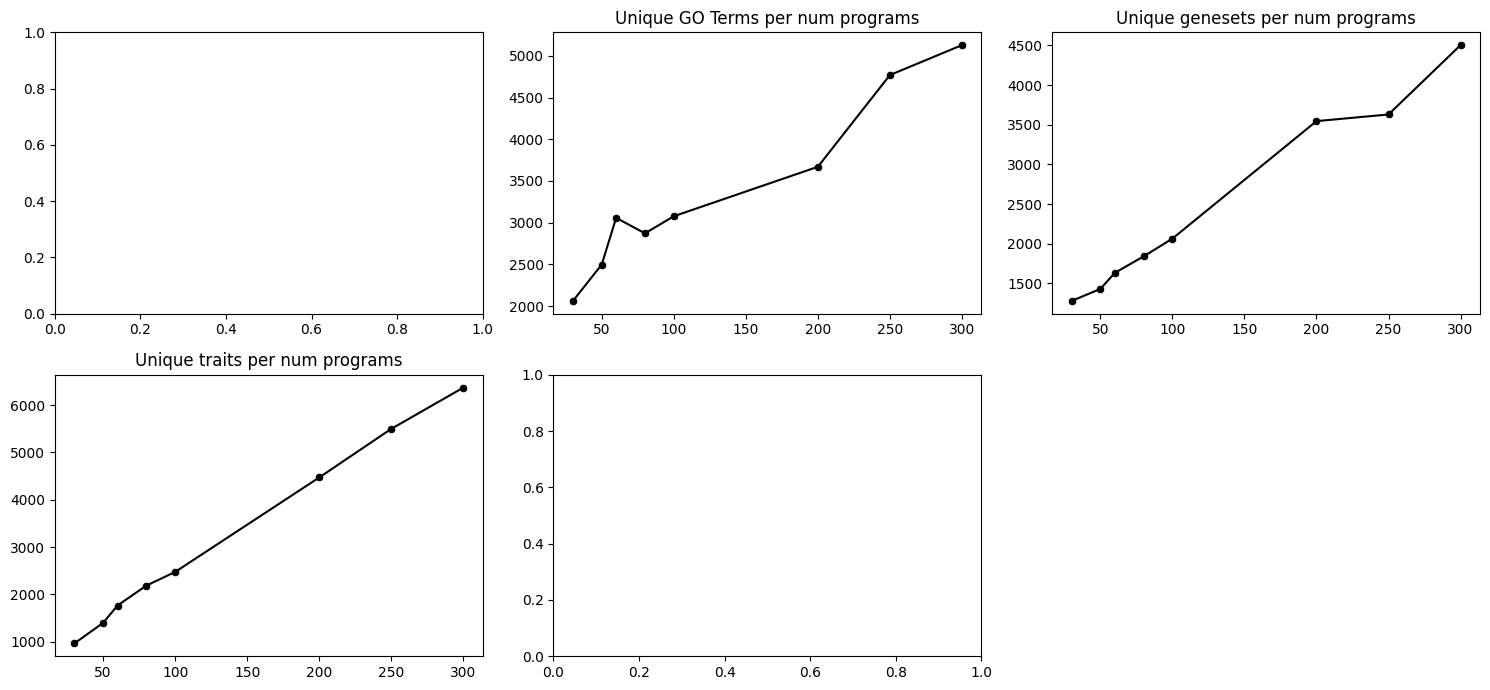

In [6]:
# Select significant K

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,7))

# Explained variance
#axs.flat[0].set_title('Unique regulators of progams (pval <=0.000335)')
#plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K', 'sample','target_name']].drop_duplicates().groupby(['K', 'sample']).count().reset_index()
#sns.lineplot(x='K', y='target_name', hue='sample', data=plotting_df, ax=axs.flat[0])

#plotting_df = test_stats_df.loc[test_stats_df.pval<=0.000335, ['K','target_name']].drop_duplicates().groupby(['K']).count().reset_index()
#sns.lineplot(x='K', y='target_name', data=plotting_df, color='black', ax=axs.flat[0])

# Unique GO Terms
sns.scatterplot(x='index', y='go_terms', data=count_df.reset_index(), ax=axs.flat[1], color='black')
sns.lineplot(x='index', y='go_terms', data=count_df.reset_index(), ax=axs.flat[1], color='black')
axs.flat[1].set_title('Unique GO Terms per num programs')

# Unique Gene sets
sns.scatterplot(x='index', y='genesets', data=count_df.reset_index(), ax=axs.flat[2], color='black')
sns.lineplot(x='index', y='genesets', data=count_df.reset_index(), ax=axs.flat[2], color='black')
axs.flat[2].set_title('Unique genesets per num programs')

# Unique Traits
sns.scatterplot(x='index', y='traits', data=count_df.reset_index(), ax=axs.flat[3], color='black')
sns.lineplot(x='index', y='traits', data=count_df.reset_index(), ax=axs.flat[3], color='black')
axs.flat[3].set_title('Unique traits per num programs')

# Unique Motifs
# sns.scatterplot(x='index', y='motifs', data=count_df.reset_index(), ax=axs.flat[5], color='black')
# sns.lineplot(x='index', y='motifs', data=count_df.reset_index(), ax=axs.flat[5], color='black')
#axs.flat[4].set_title('Unique motifs per num programs')

for ax in axs.flat[:]:
    ax.set_xlabel('')
    ax.set_ylabel('')
axs.flat[-1].axis('off')

plt.tight_layout()
plt.savefig('cNMF_k_selection_evaluations.png', dpi=100)

In [31]:
# Select K
sel_K = 100

In [ ]:
# # Process anndata
# mdata = mudata.read('../240701_cNMF/cNMF_{}_0.2_gene_names.h5mu'.format(sel_K))
# scp.pp.log1p(mdata['rna'])
# scp.pp.pca(mdata['rna'], n_comps=sel_K)
# scp.pp.neighbors(mdata['rna'], n_neighbors=30)
# scp.tl.umap(mdata['rna'])

# mdata['cNMF'].obsm['X_umap'] = mdata['rna'].obsm['X_umap']


/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the 

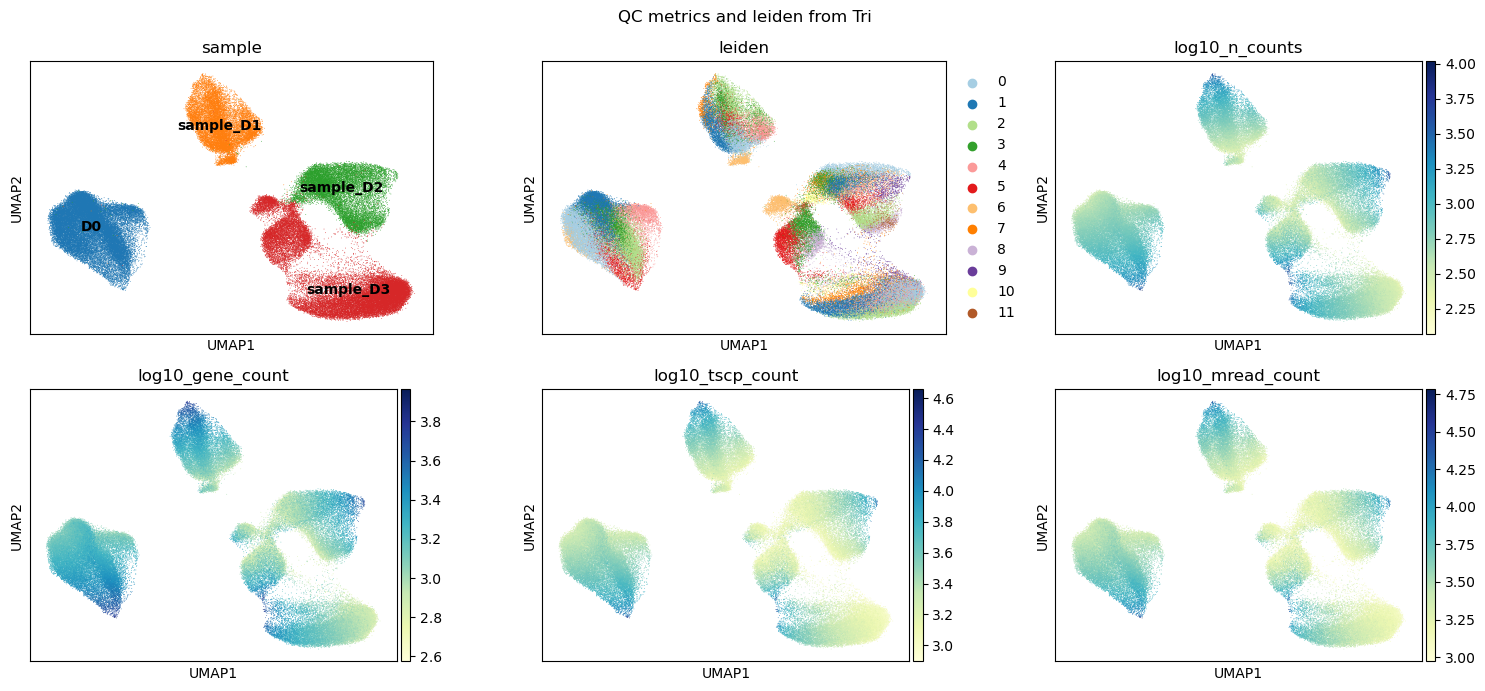

In [19]:
# fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,7))

# scp.pl.umap(mdata['rna'], color='sample', legend_loc='on data', ax=axs.flat[0], save=False, show=False)
# scp.pl.umap(mdata['rna'], color='leiden', palette='Paired', ax=axs.flat[1], save=False, show=False)

# for i, col in enumerate(['n_counts', 'gene_count', 'tscp_count', 'mread_count']):
#     mdata['rna'].obs['log10_{}'.format(col)] = mdata['rna'].obs[col].apply(lambda x: np.log10(x))
#     scp.pl.umap(mdata['rna'], color='log10_{}'.format(col), cmap='YlGnBu', ax=axs.flat[i+2], save=False, show=False)

# fig.suptitle('QC metrics and leiden from Tri')
# plt.tight_layout()
# plt.savefig('UMAP.png')

In [11]:
# Create guide metadata df
guide_assignment = []
for i, guide in enumerate(mdata['cNMF'].uns['guide_names']):

    tmp_df = pd.DataFrame(index=mdata['rna'].obs.index[mdata['cNMF'].obsm['guide_assignment'][:, i].astype(bool)])
    tmp_df.index.name='barcode'
    tmp_df['guide'] = guide
    tmp_df['target'] = mdata['cNMF'].uns['guide_targets'][i]
    guide_assignment.append(tmp_df)
    tmp_df.reset_index(inplace=True, drop=False)

guide_assignment = pd.concat(guide_assignment, ignore_index=True)
guide_metadata_df = guide_assignment.merge(mdata['rna'].obs, left_on='barcode', right_index=True, how='left')
guide_metadata_df.head()


,barcode,guide,target,sample,species,gene_count,tscp_count,mread_count,leiden,n_counts,log10_n_counts,log10_gene_count,log10_tscp_count,log10_mread_count
0,01_11_94__s1,ACAA1_-_38178575.23-P1P2,ACAA1,D0,hg38,1748,2904,3905,0,627.0,2.797268,3.242541,3.462997,3.591621
1,01_22_85__s1,ACAA1_-_38178575.23-P1P2,ACAA1,D0,hg38,3878,7971,10895,5,1704.0,3.231470,3.588608,3.901513,4.037227
2,02_29_14__s1,ACAA1_-_38178575.23-P1P2,ACAA1,D0,hg38,1472,2287,3073,3,423.0,2.626340,3.167908,3.359266,3.487563
3,02_33_18__s1,ACAA1_-_38178575.23-P1P2,ACAA1,D0,hg38,1512,2254,2999,0,473.0,2.674861,3.179552,3.352954,3.476976
4,04_28_93__s1,ACAA1_-_38178575.23-P1P2,ACAA1,D0,hg38,1596,2422,3233,0,452.0,2.655138,3.203033,3.384174,3.509606


In [ ]:
# Load perturbation data
perturb_df = pd.read_csv('../240807_cNMF_eval_pipeline_analysis/{}/{}_mean_program_score_per_target.txt'.format(sel_K, sel_K), sep='\t')

/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


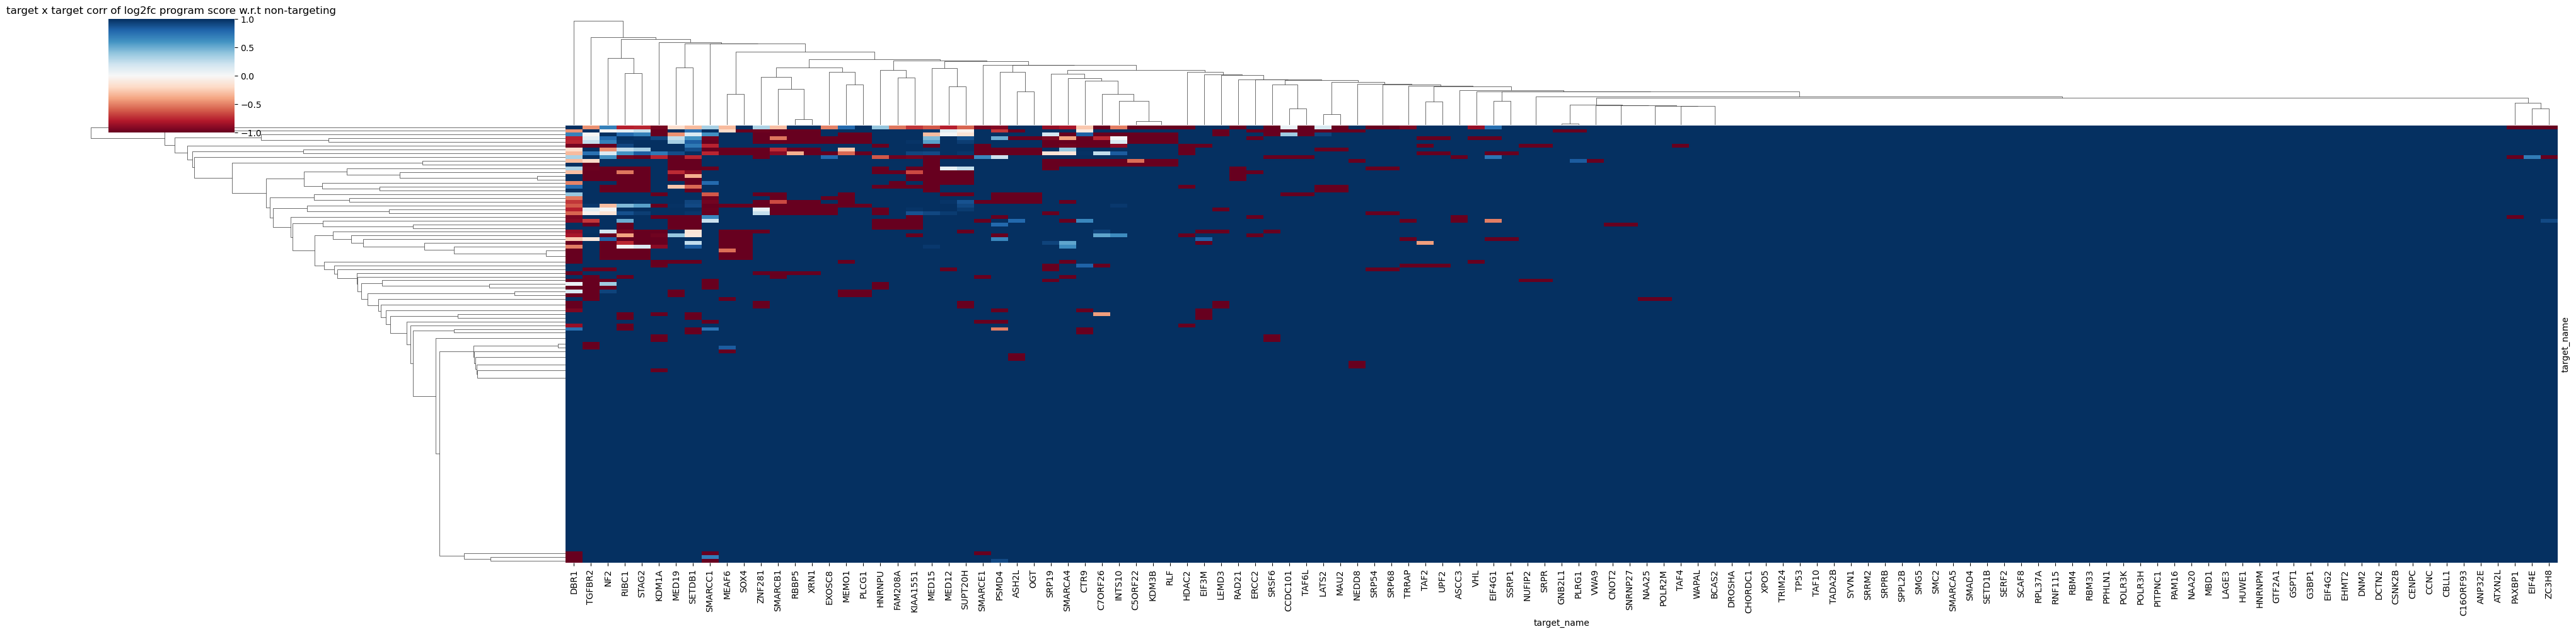

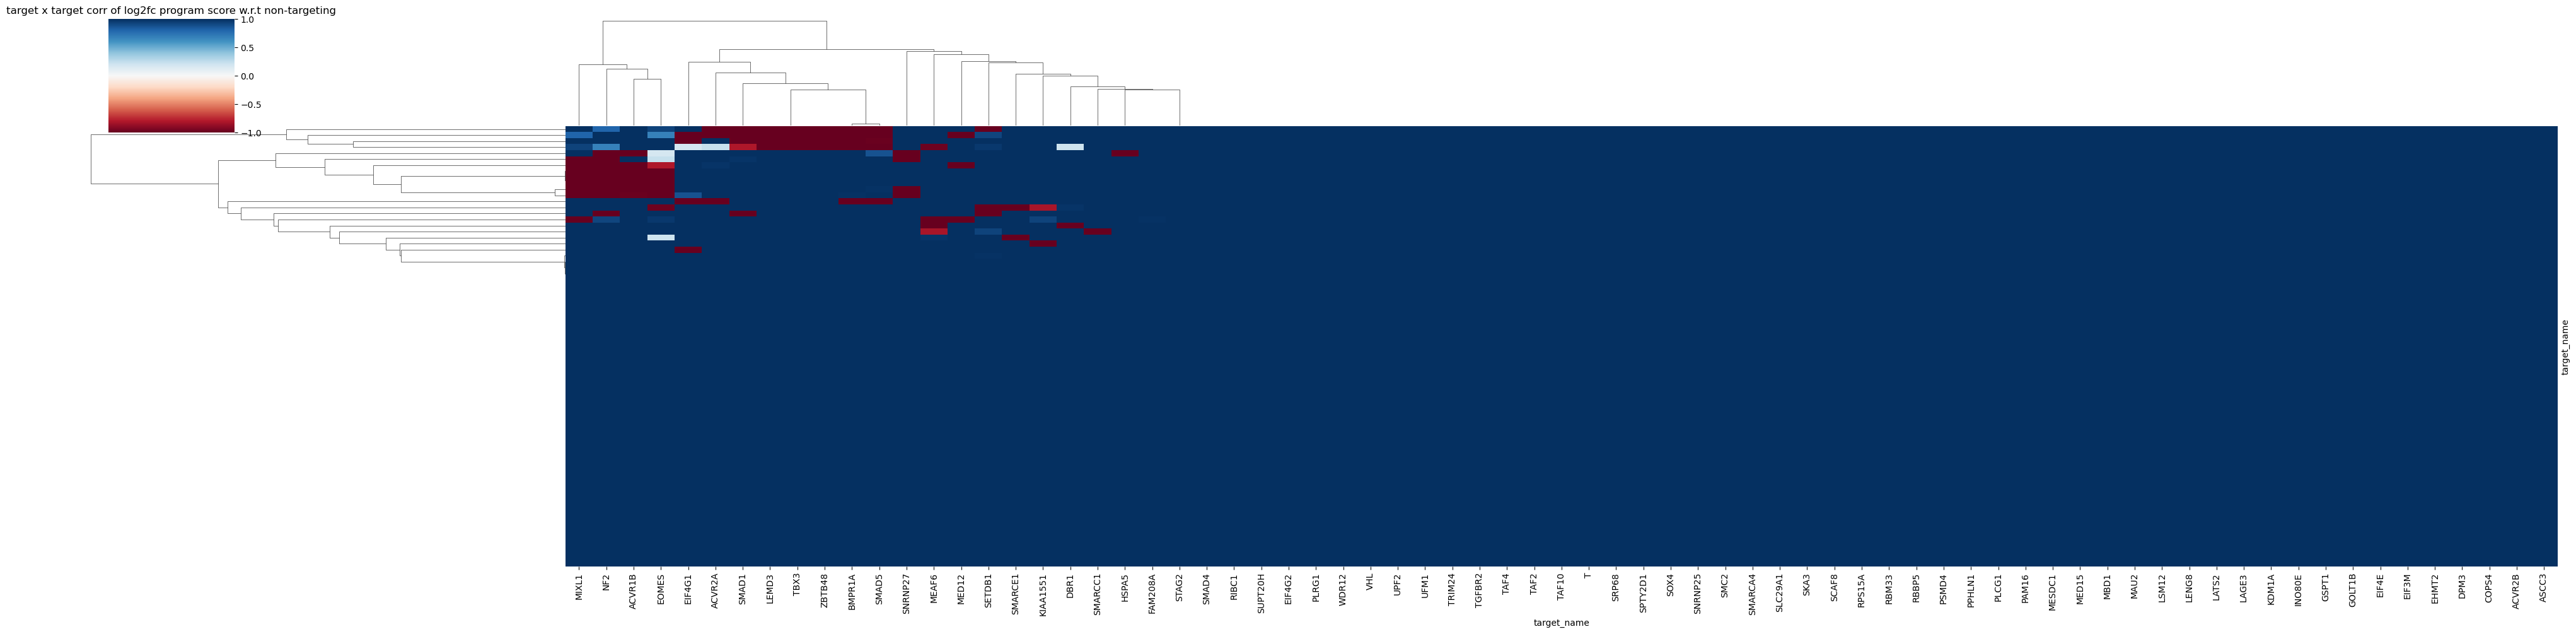

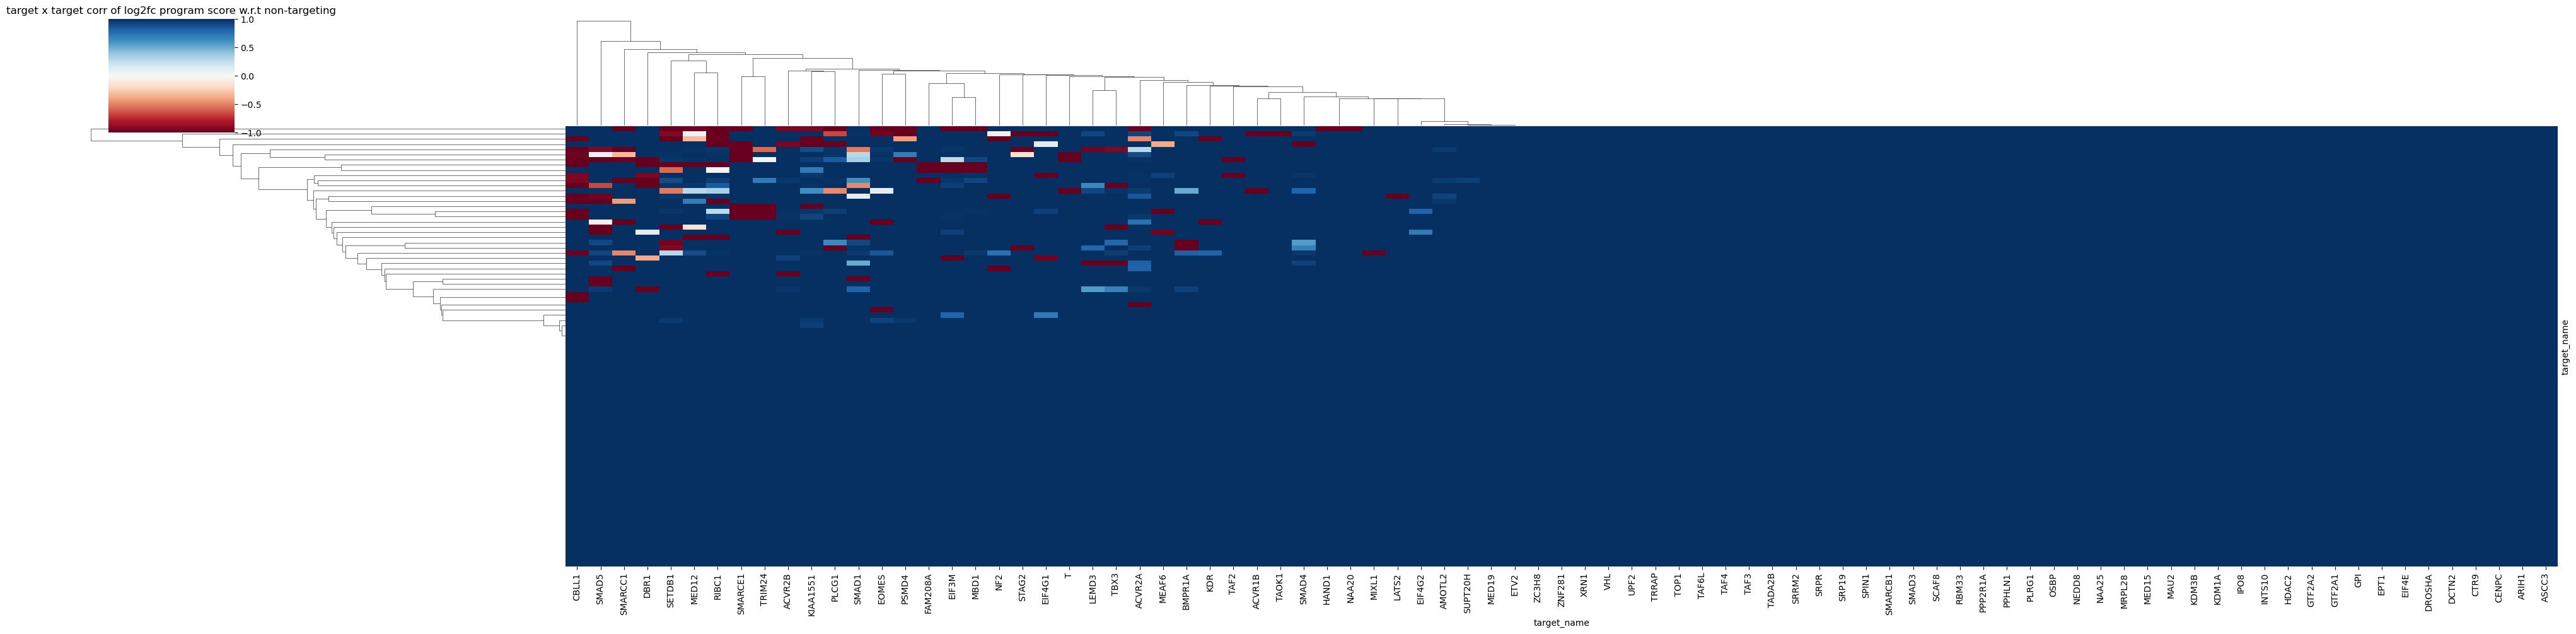

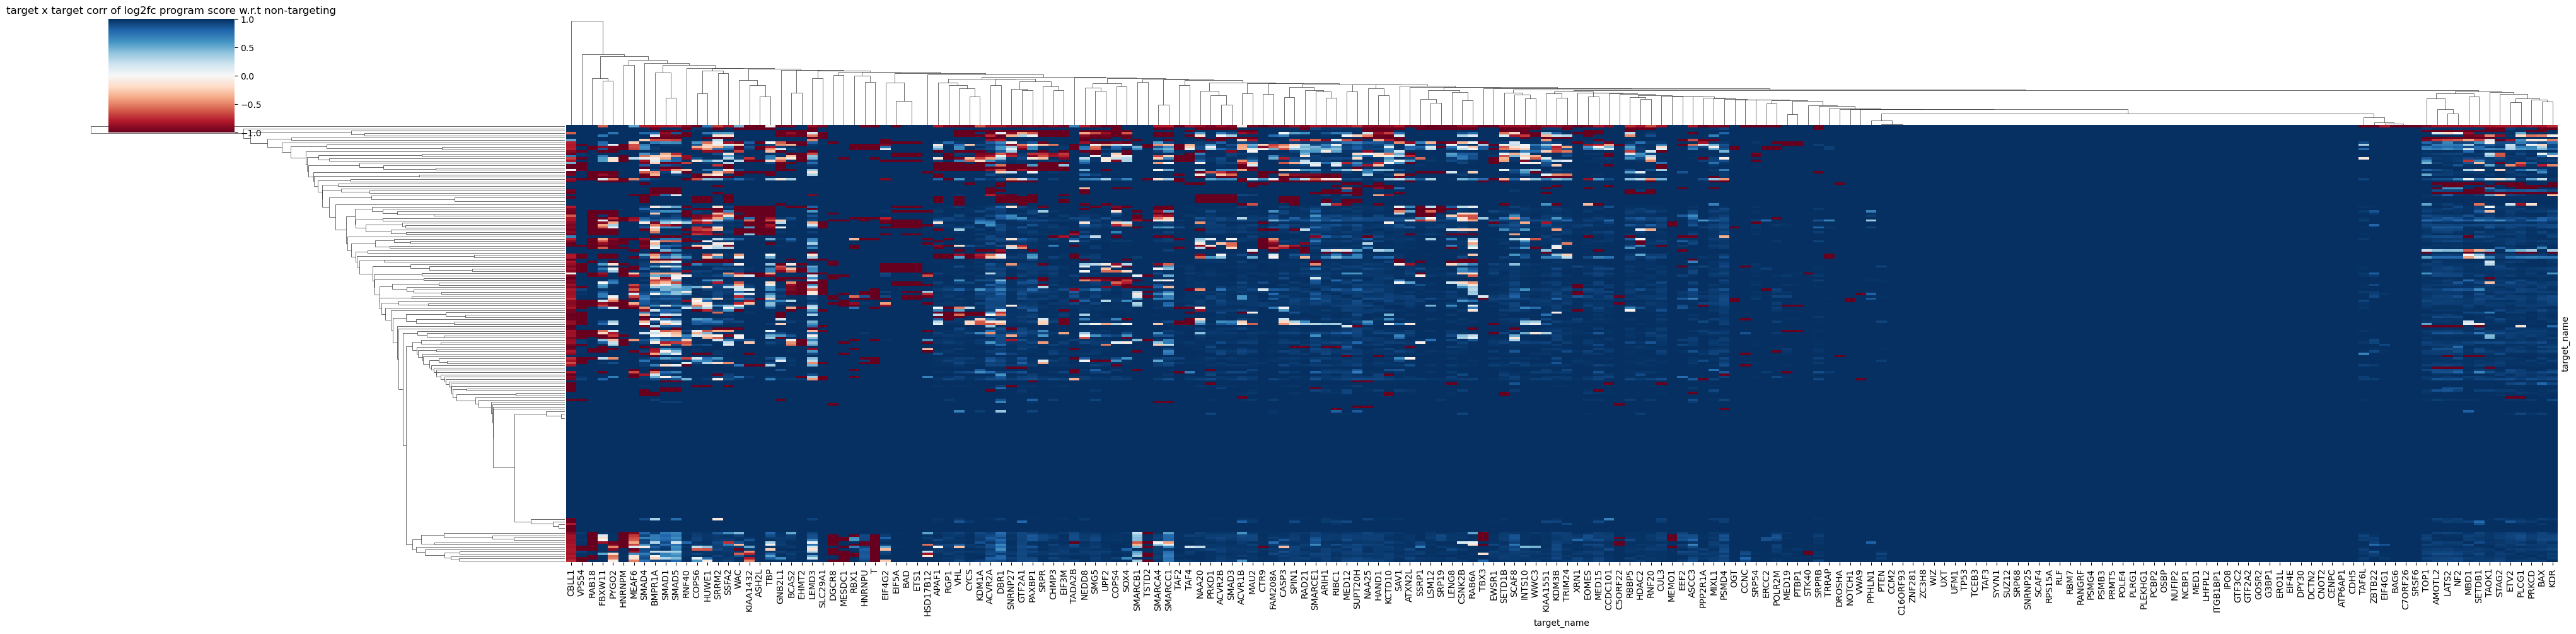

In [ ]:
# Correlation target x target based on mean program scores - table aswell
for samp in perturb_df['sample'].unique():
    perturb_df_ = perturb_df.loc[perturb_df['sample']==samp]
    perturb_df_ = perturb_df_.loc[perturb_df_.pval<=0.000335]

    corr_df = perturb_df_.pivot(index='program_name', columns='target_name', values='log2fc_over_non_targeting_mean_program_score').corr().fillna(1)
    corr_df.to_csv('{}/{}_target_x_target_correlation_cNMF_perturbation_effect_{}.txt'.format(sel_K, sel_K, samp), sep='\t')

    clus = sns.clustermap(corr_df, cmap='RdBu', xticklabels=True, yticklabels=False, figsize=(40,10))
    plt.title('target x target corr of log2fc program score w.r.t non-targeting')
    plt.savefig('{}/{}_target_x_target_correlation_cNMF_perturbation_effect_{}.png'.format(sel_K, sel_K, samp), dpi=100)

/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


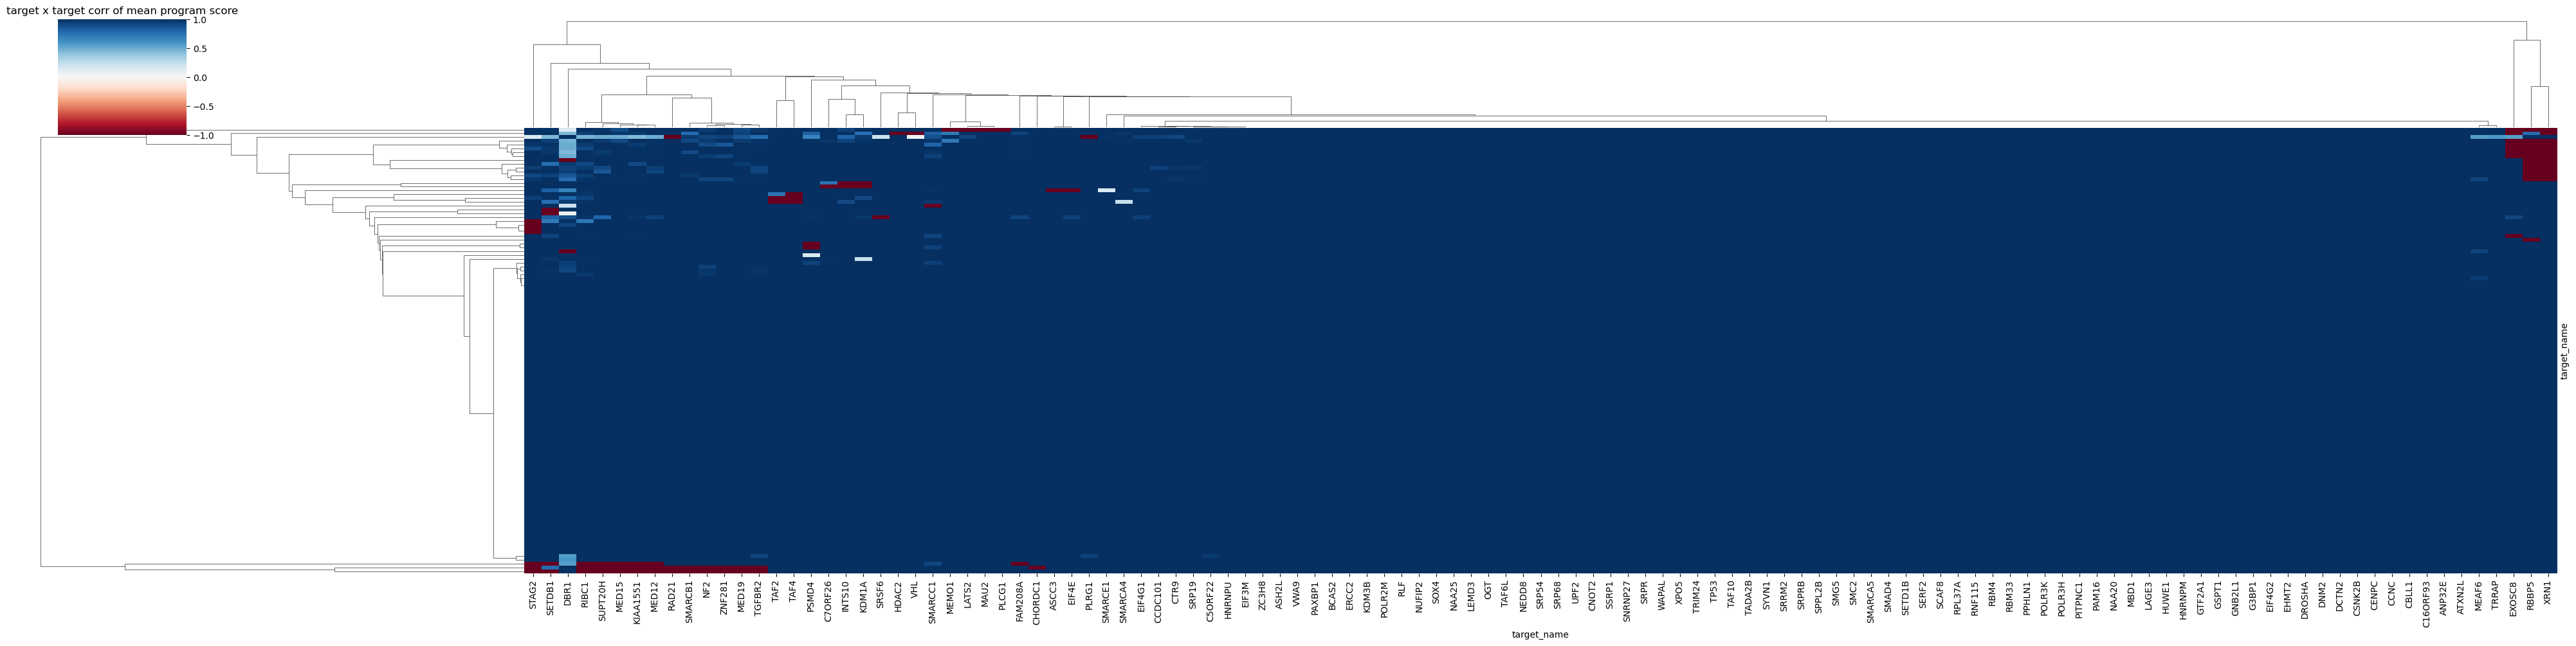

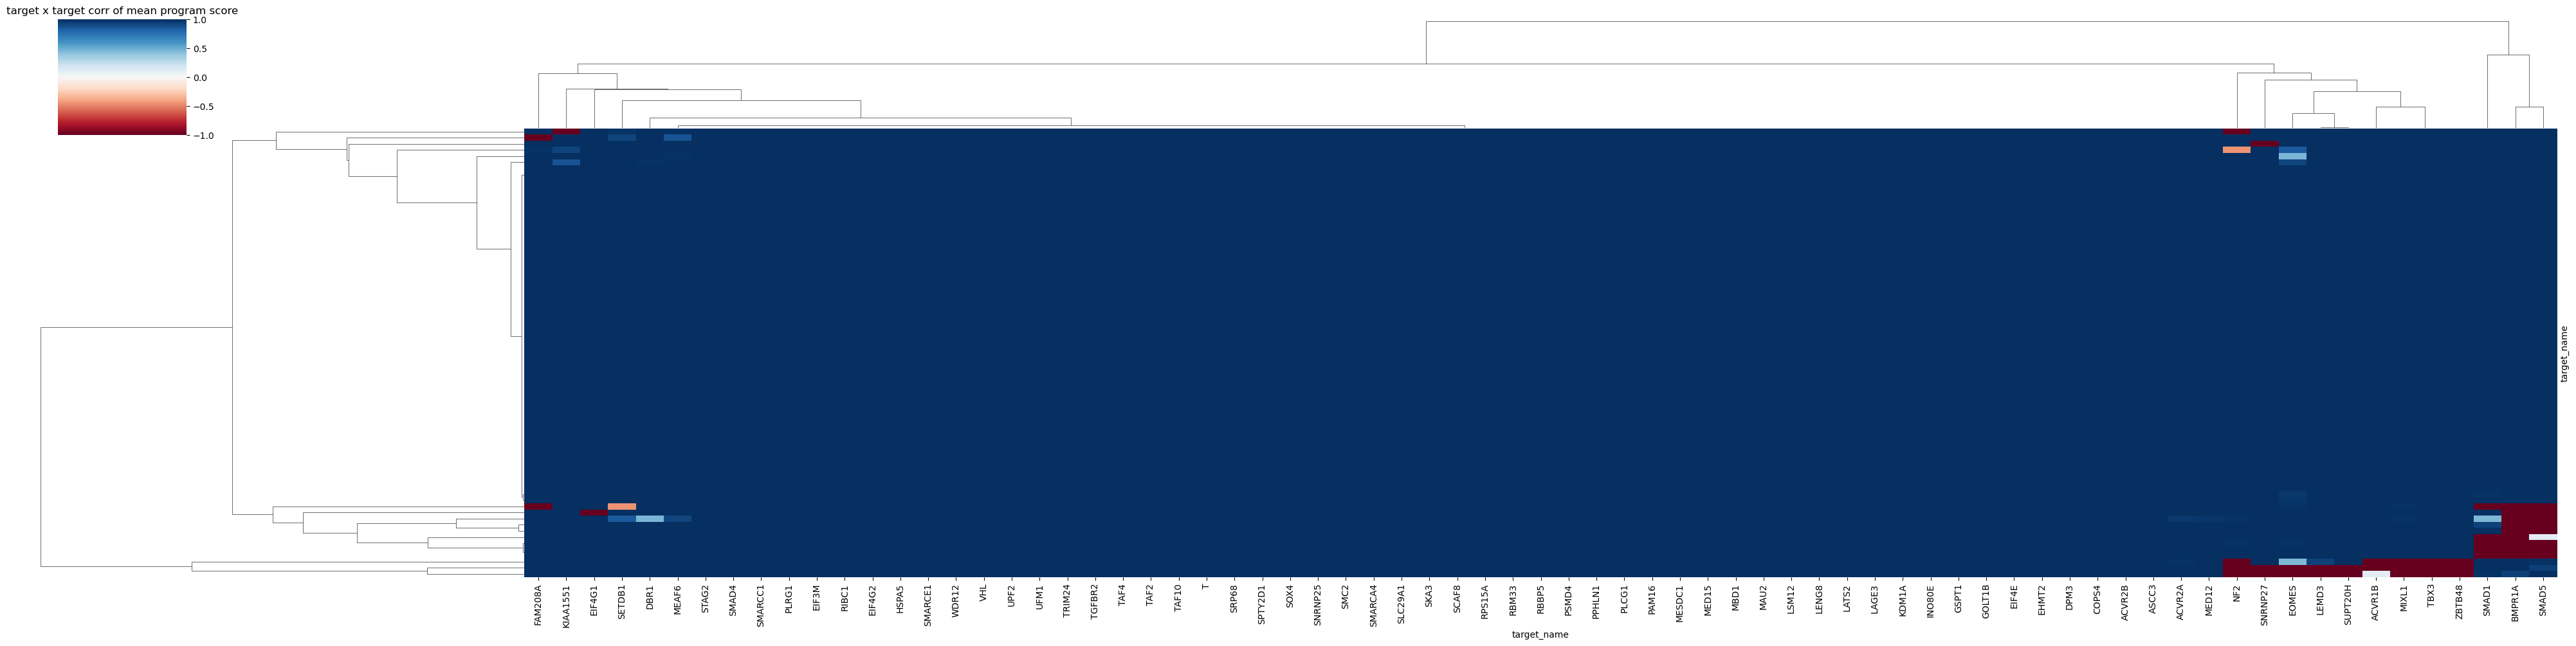

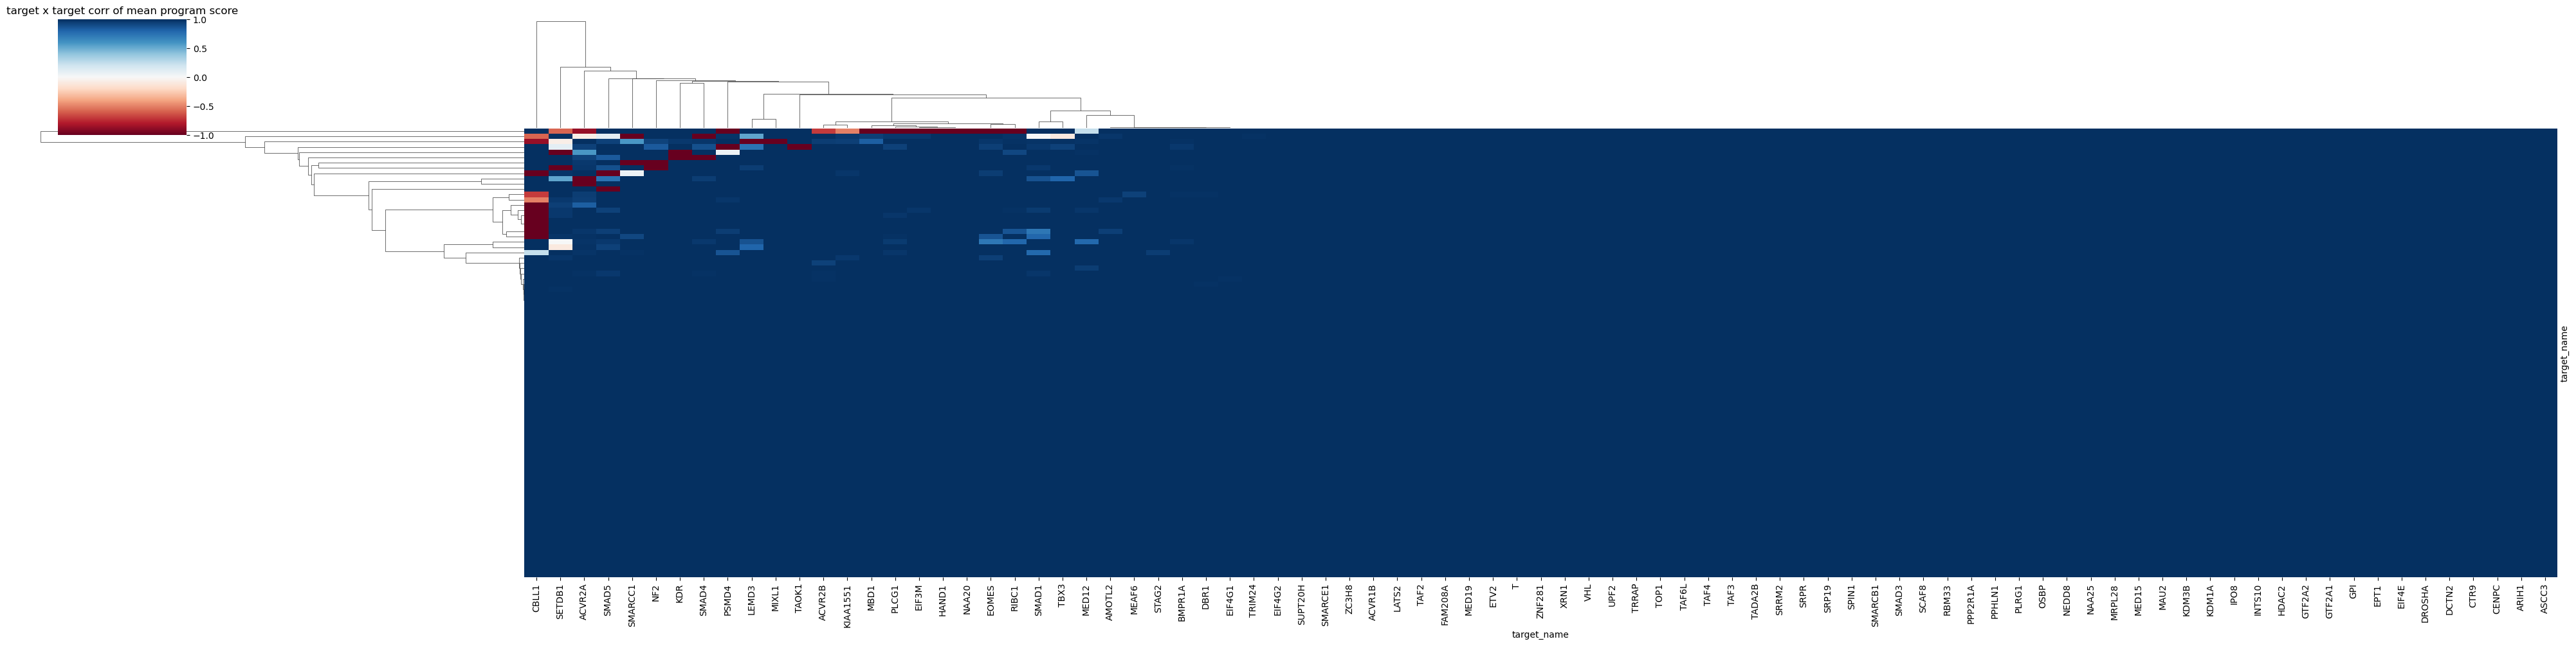

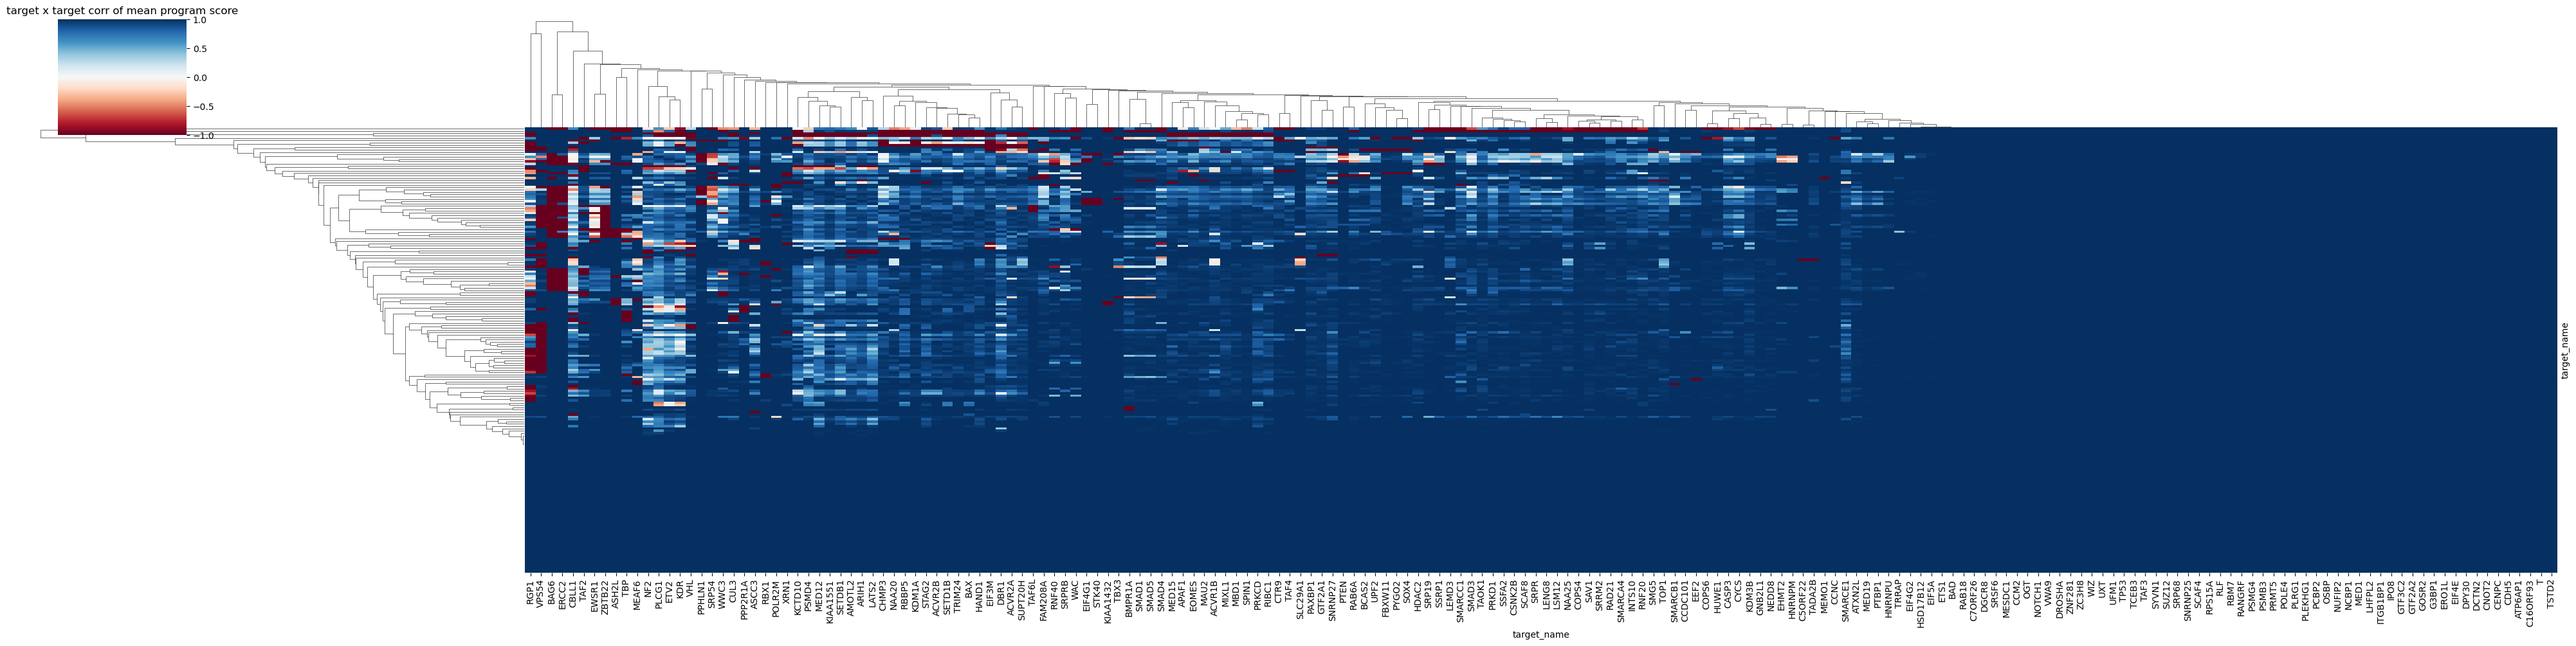

In [ ]:
# Correlation target x target based on mean program scores - table aswell

for samp in perturb_df['sample'].unique():

    perturb_df_ = perturb_df.loc[perturb_df['sample']==samp]
    perturb_df_ = perturb_df_.loc[perturb_df_.pval<=0.000335]

    corr_df = perturb_df_.pivot(index='program_name', columns='target_name', values='mean_program_score').corr().fillna(1)
    corr_df.to_csv('{}/{}_target_x_target_correlation_cNMF_perturbation_effect_mean_score_{}.txt'.format(sel_K, sel_K, samp), sep='\t')

    clus = sns.clustermap(corr_df, cmap='RdBu', xticklabels=True, yticklabels=False, figsize=(40,10))
    plt.title('target x target corr of mean program score')
    plt.savefig('{}/{}_target_x_target_correlation_cNMF_perturbation_effect_mean_score_{}.png'.format(sel_K, sel_K, samp), dpi=100)

/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


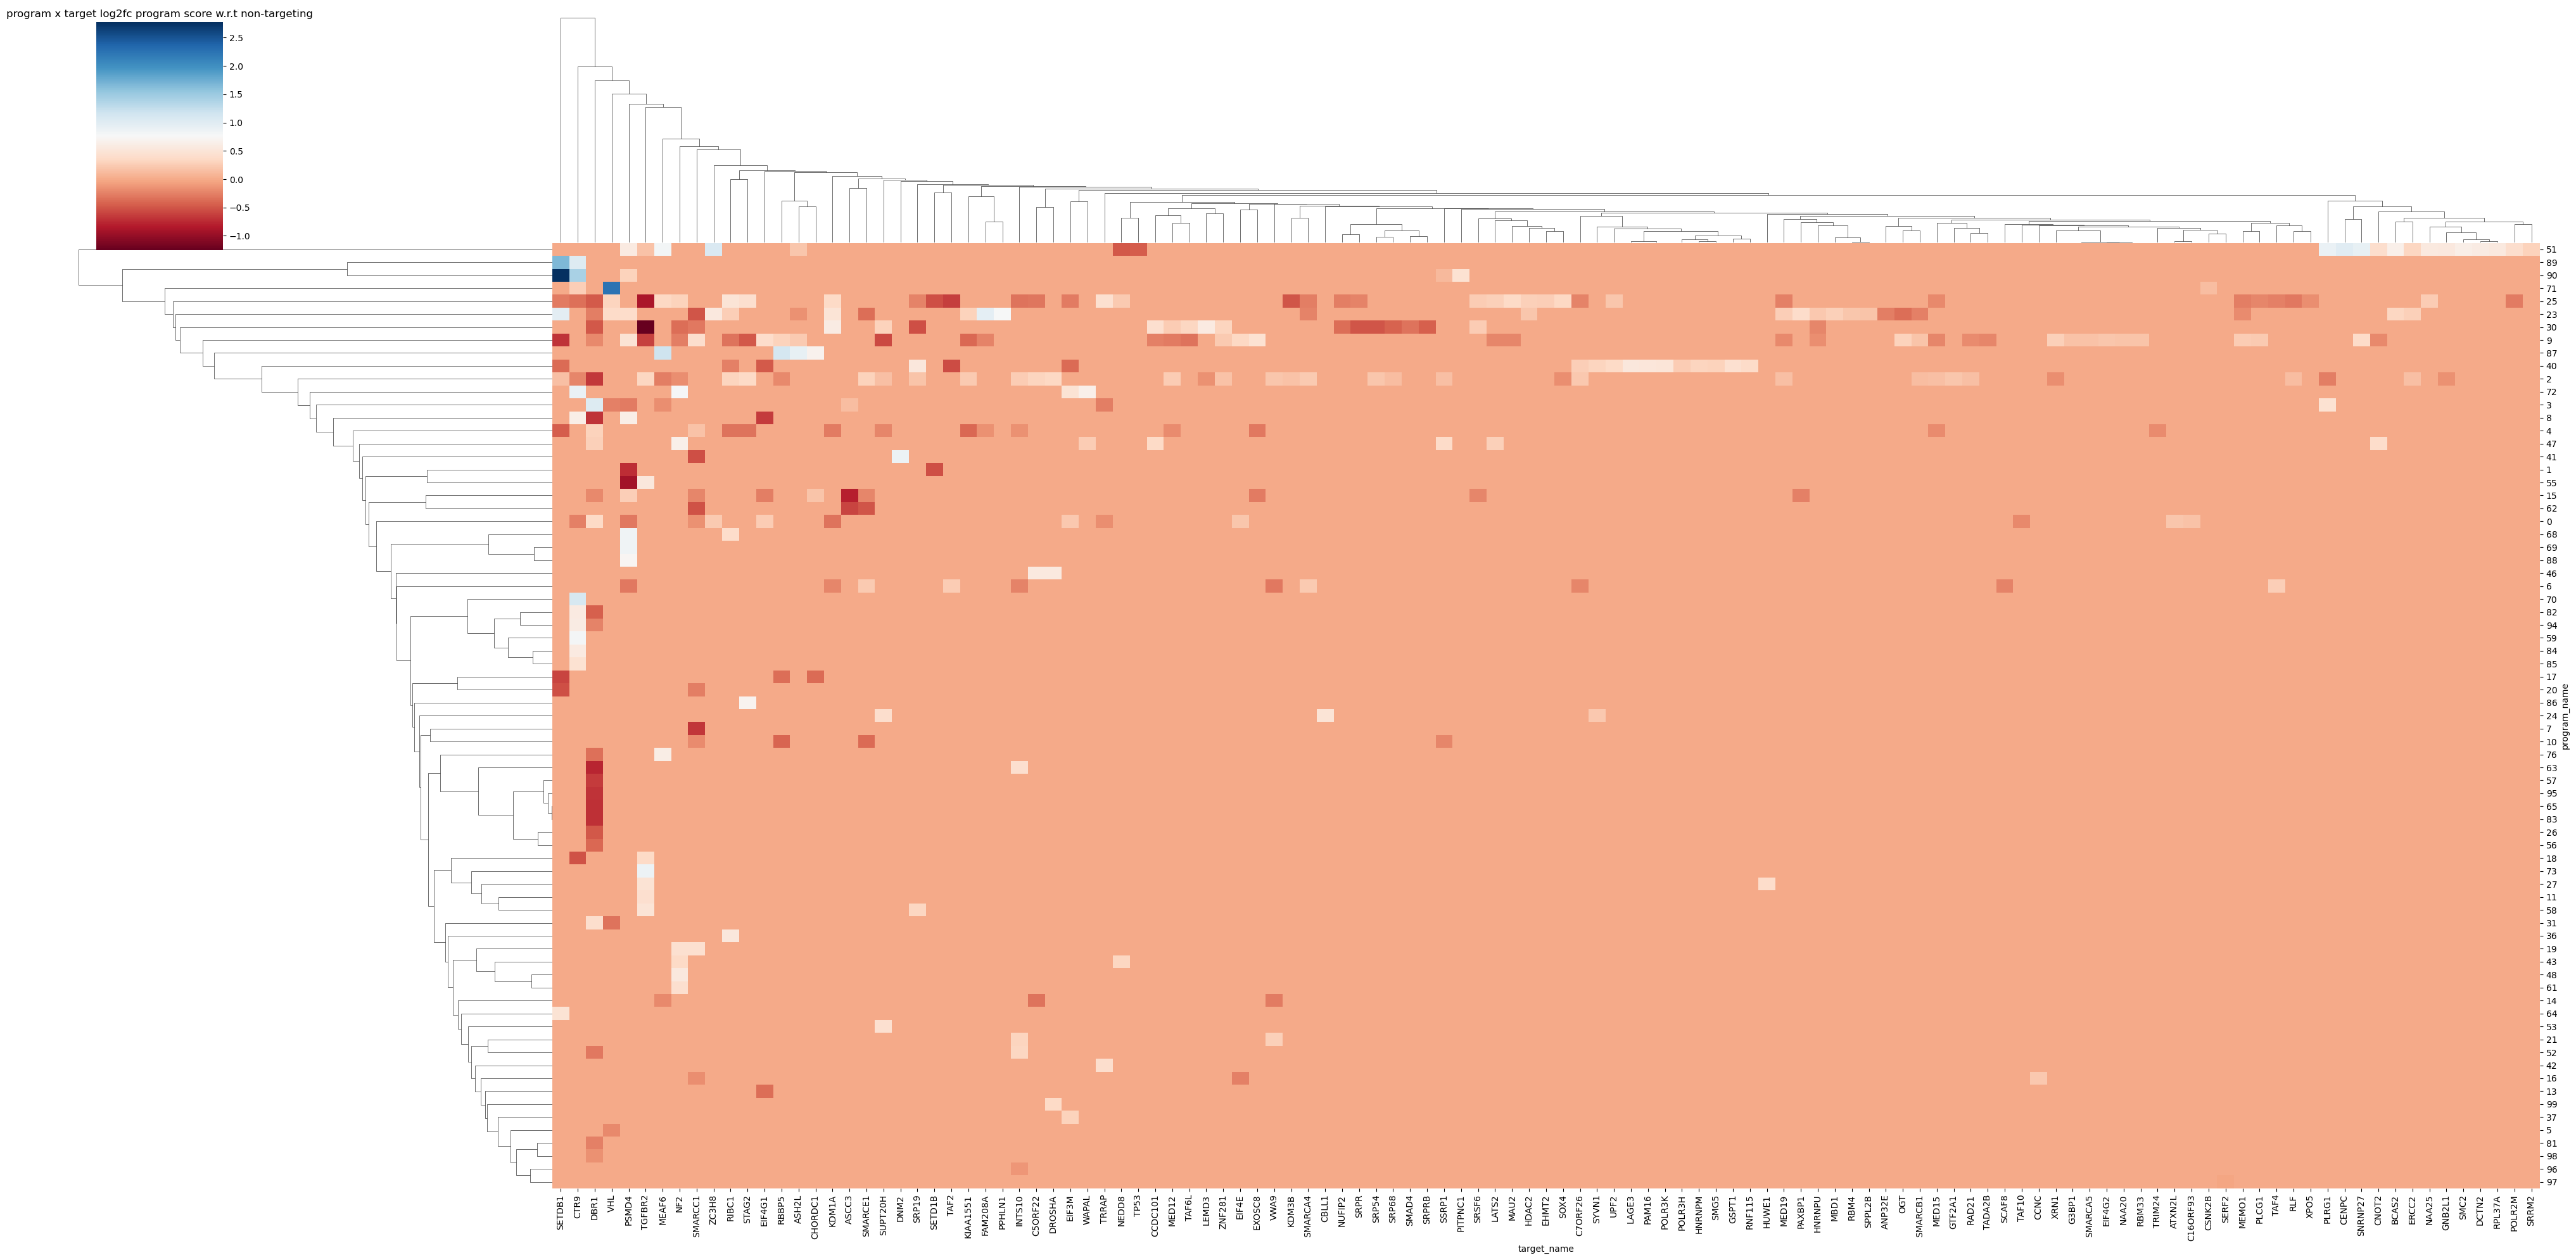

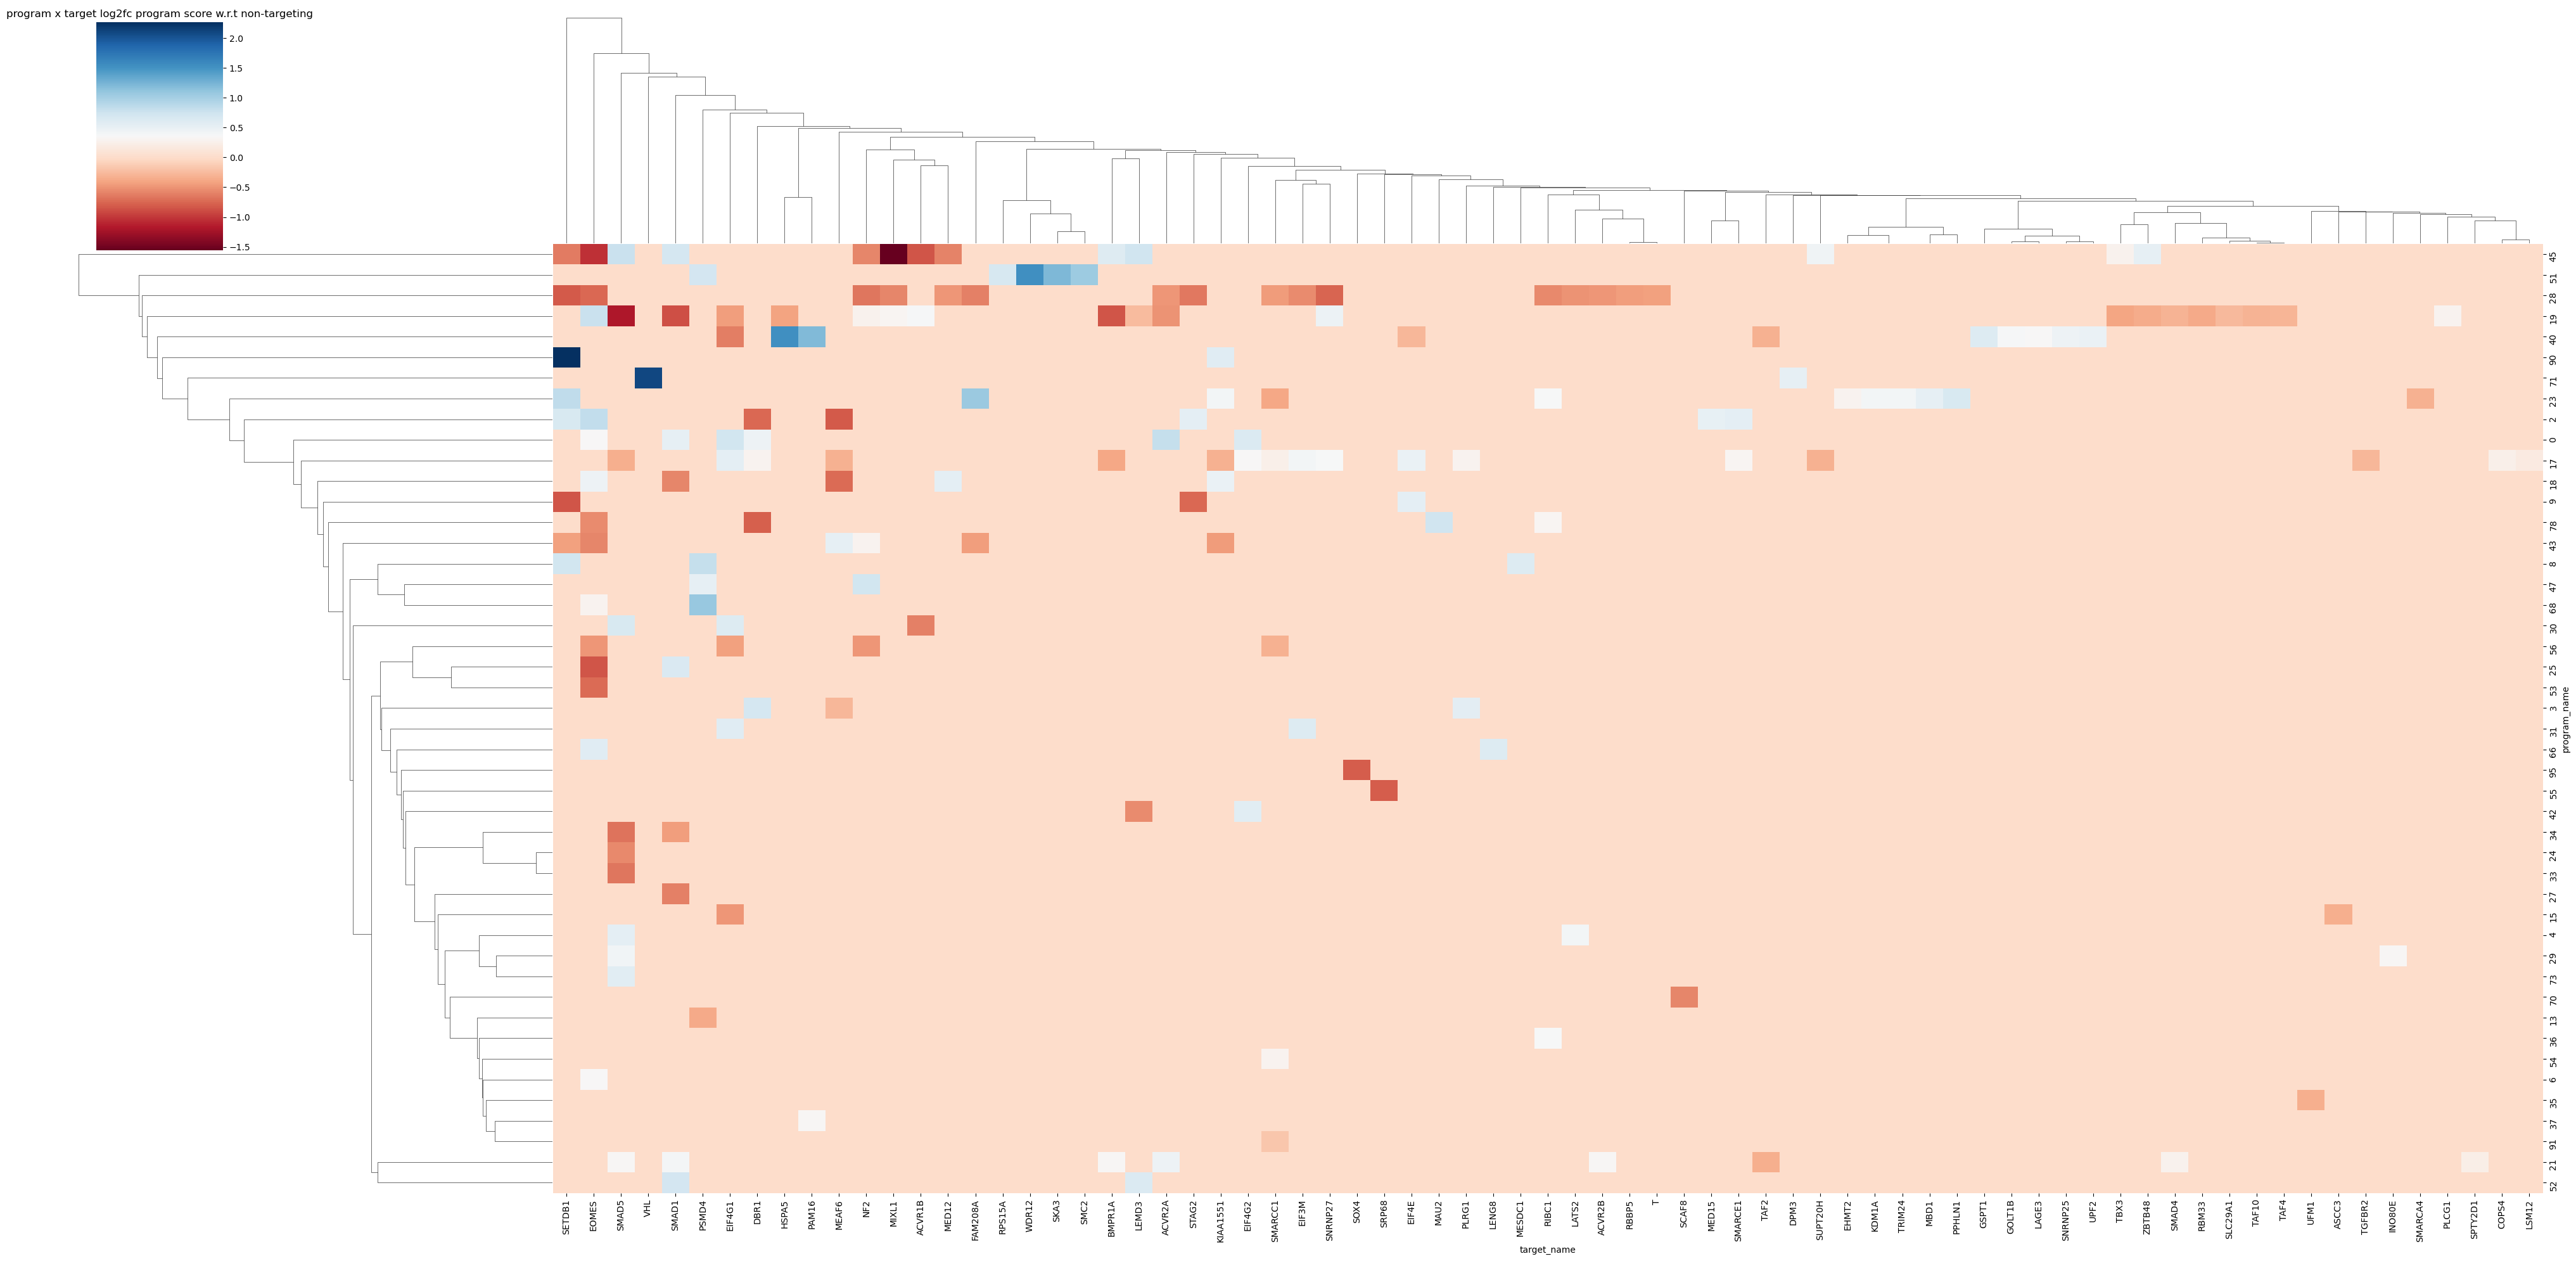

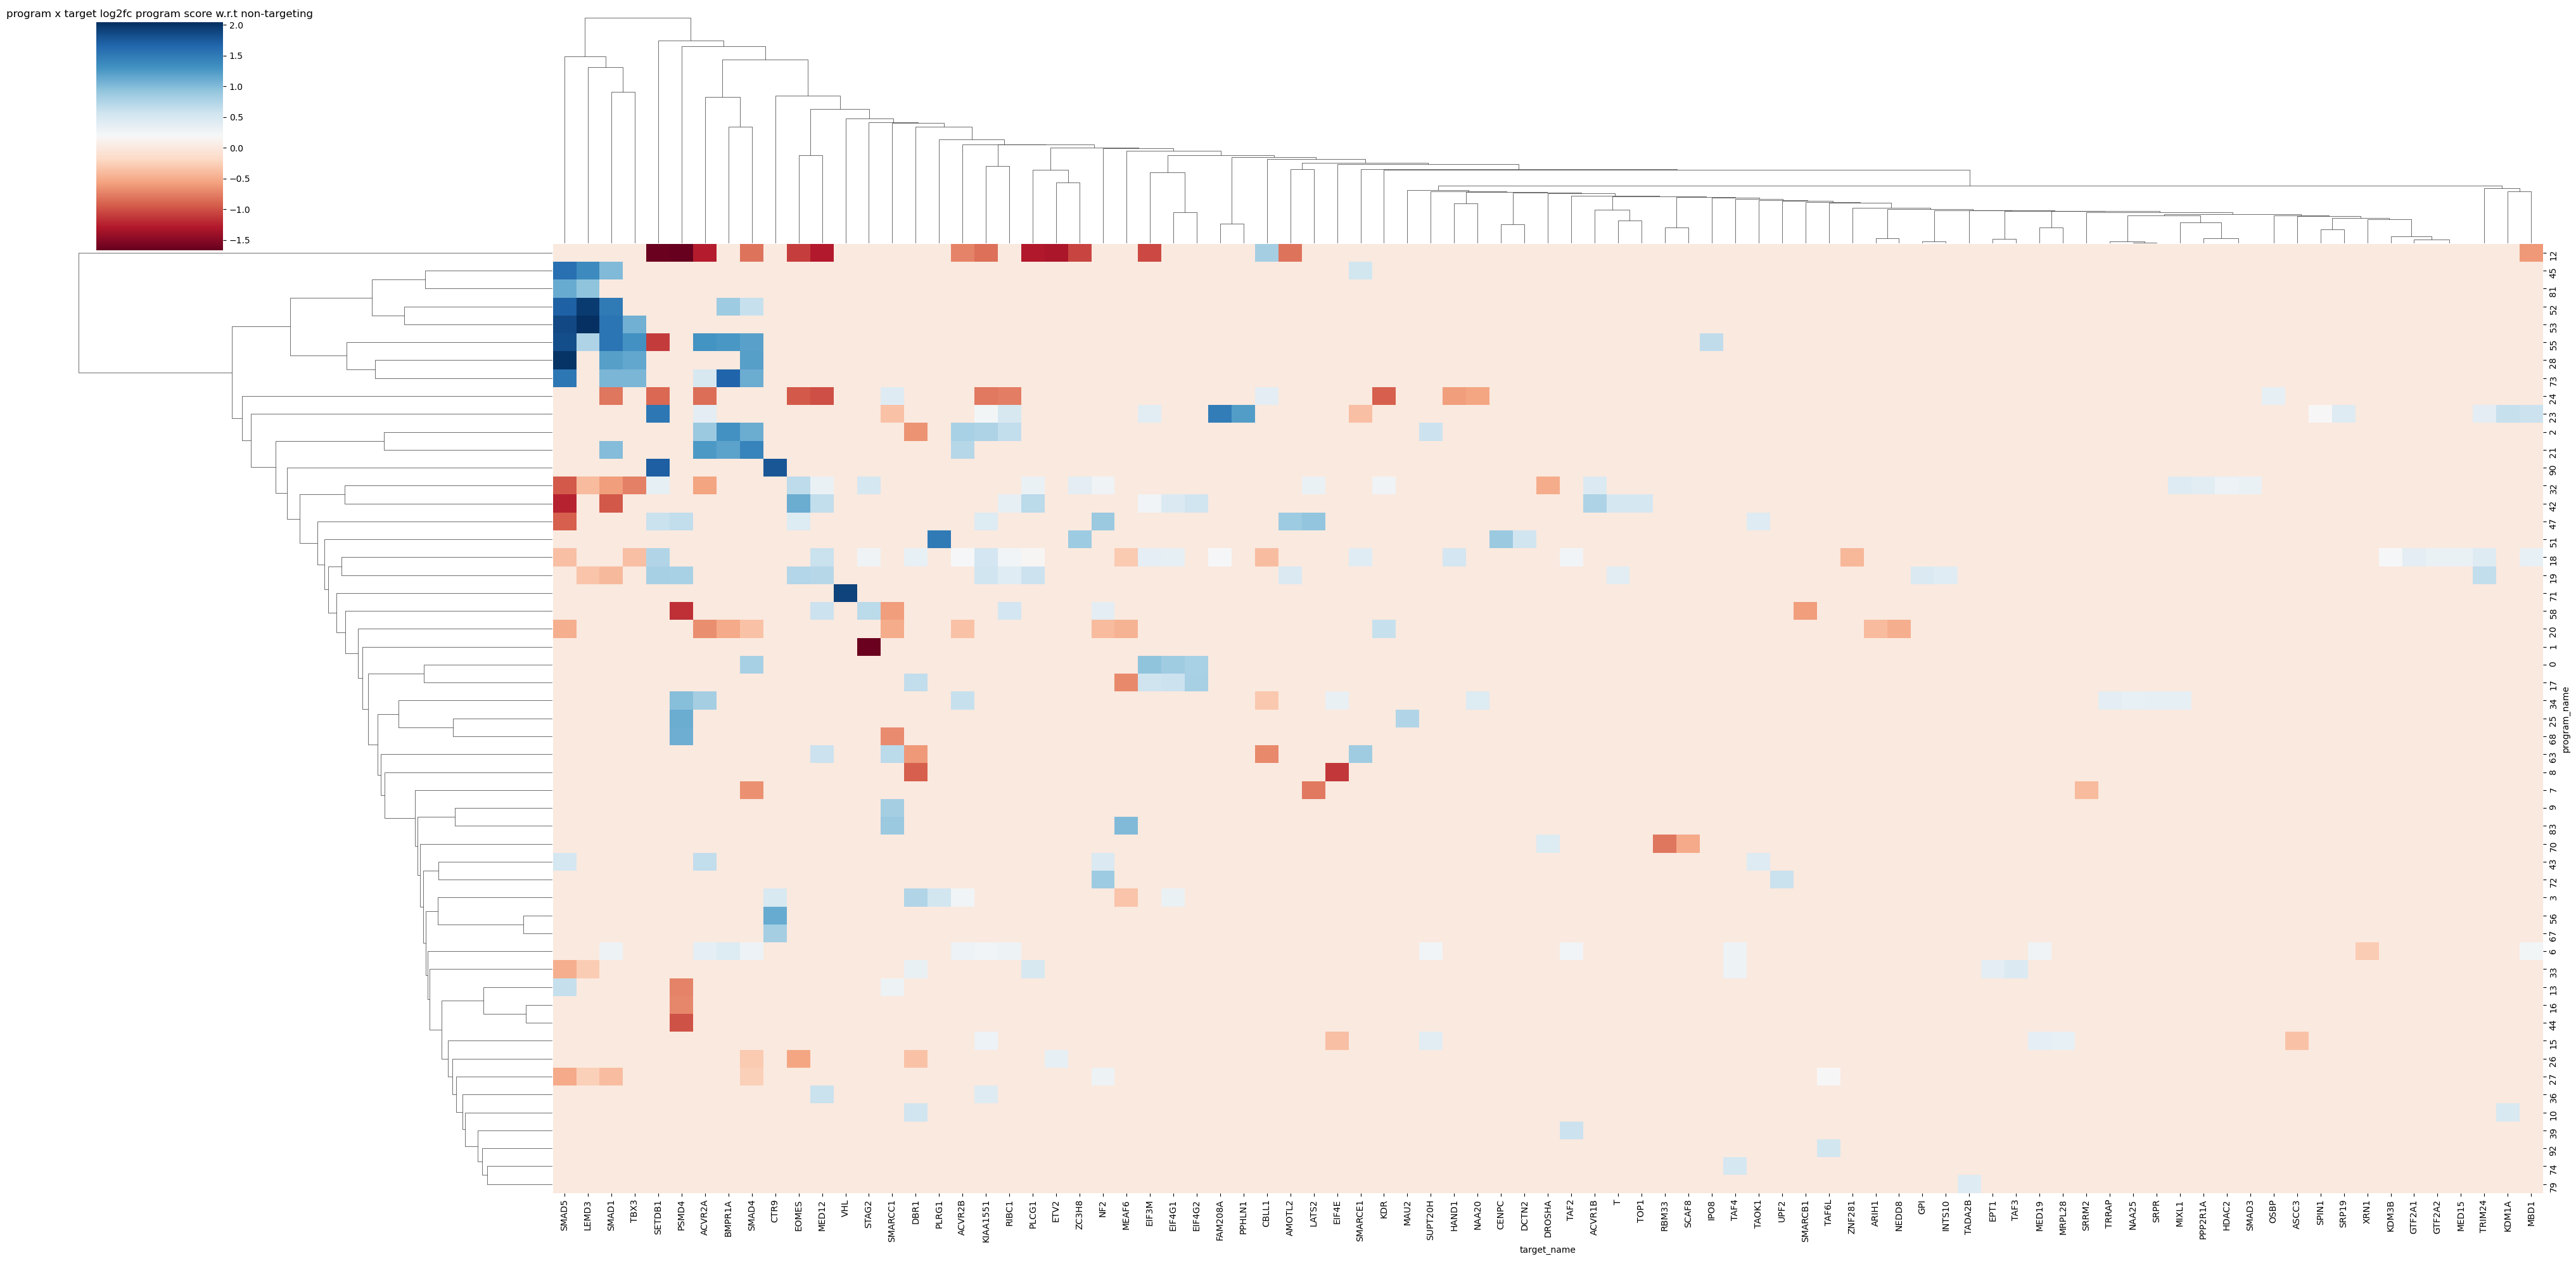

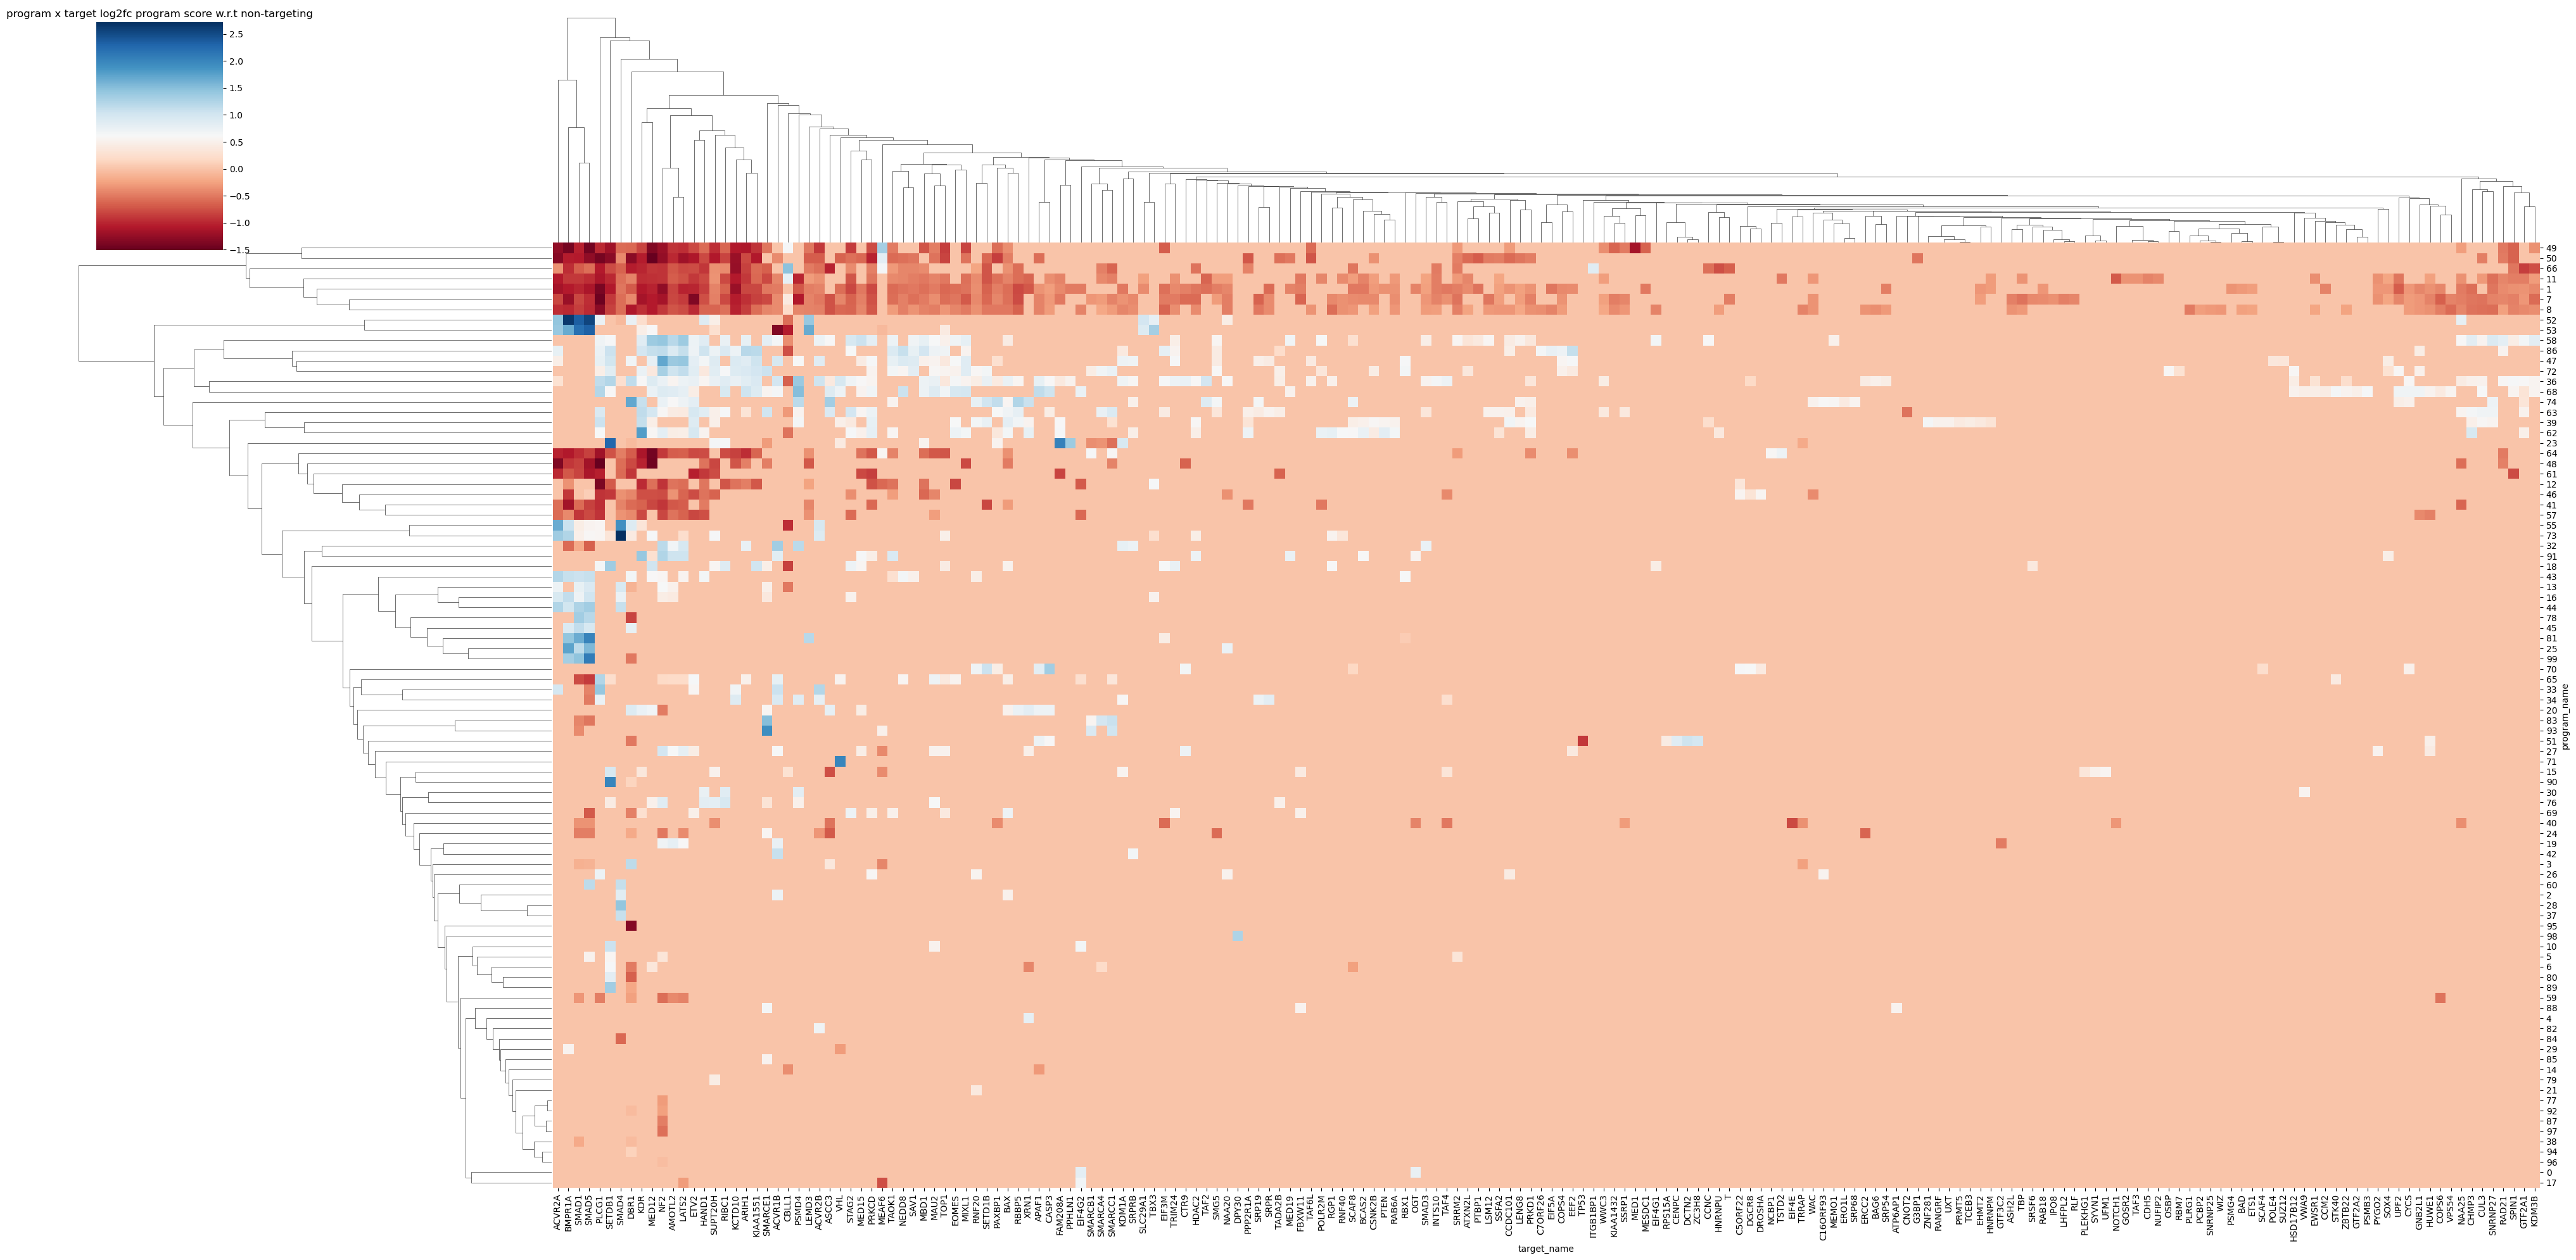

In [ ]:
# Heatmaps log2fc and mean score

for samp in perturb_df['sample'].unique():

    perturb_df_ = perturb_df.loc[perturb_df['sample']==samp]
    perturb_df_ = perturb_df_.loc[perturb_df_.pval<=0.000335]

    plot_df =perturb_df_.pivot(index='program_name', columns='target_name', values='log2fc_over_non_targeting_mean_program_score').astype(float)
    plot_df.to_csv('{}/{}_program_x_target_cNMF_perturbation_effect_{}.txt'.format(sel_K, sel_K, samp), sep='\t')
    plot_df = plot_df.fillna(0)

    sns.clustermap(plot_df, xticklabels=True, yticklabels=True, cmap='RdBu', figsize=(40,20))
    plt.title('program x target log2fc program score w.r.t non-targeting')
    plt.savefig('{}/{}_program_x_target_cNMF_perturbation_effect_{}.png'.format(sel_K, sel_K, samp), dpi=100)

/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/oak/stanford/groups/akundaje/regu/miniforge3/envs/sc_analysis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


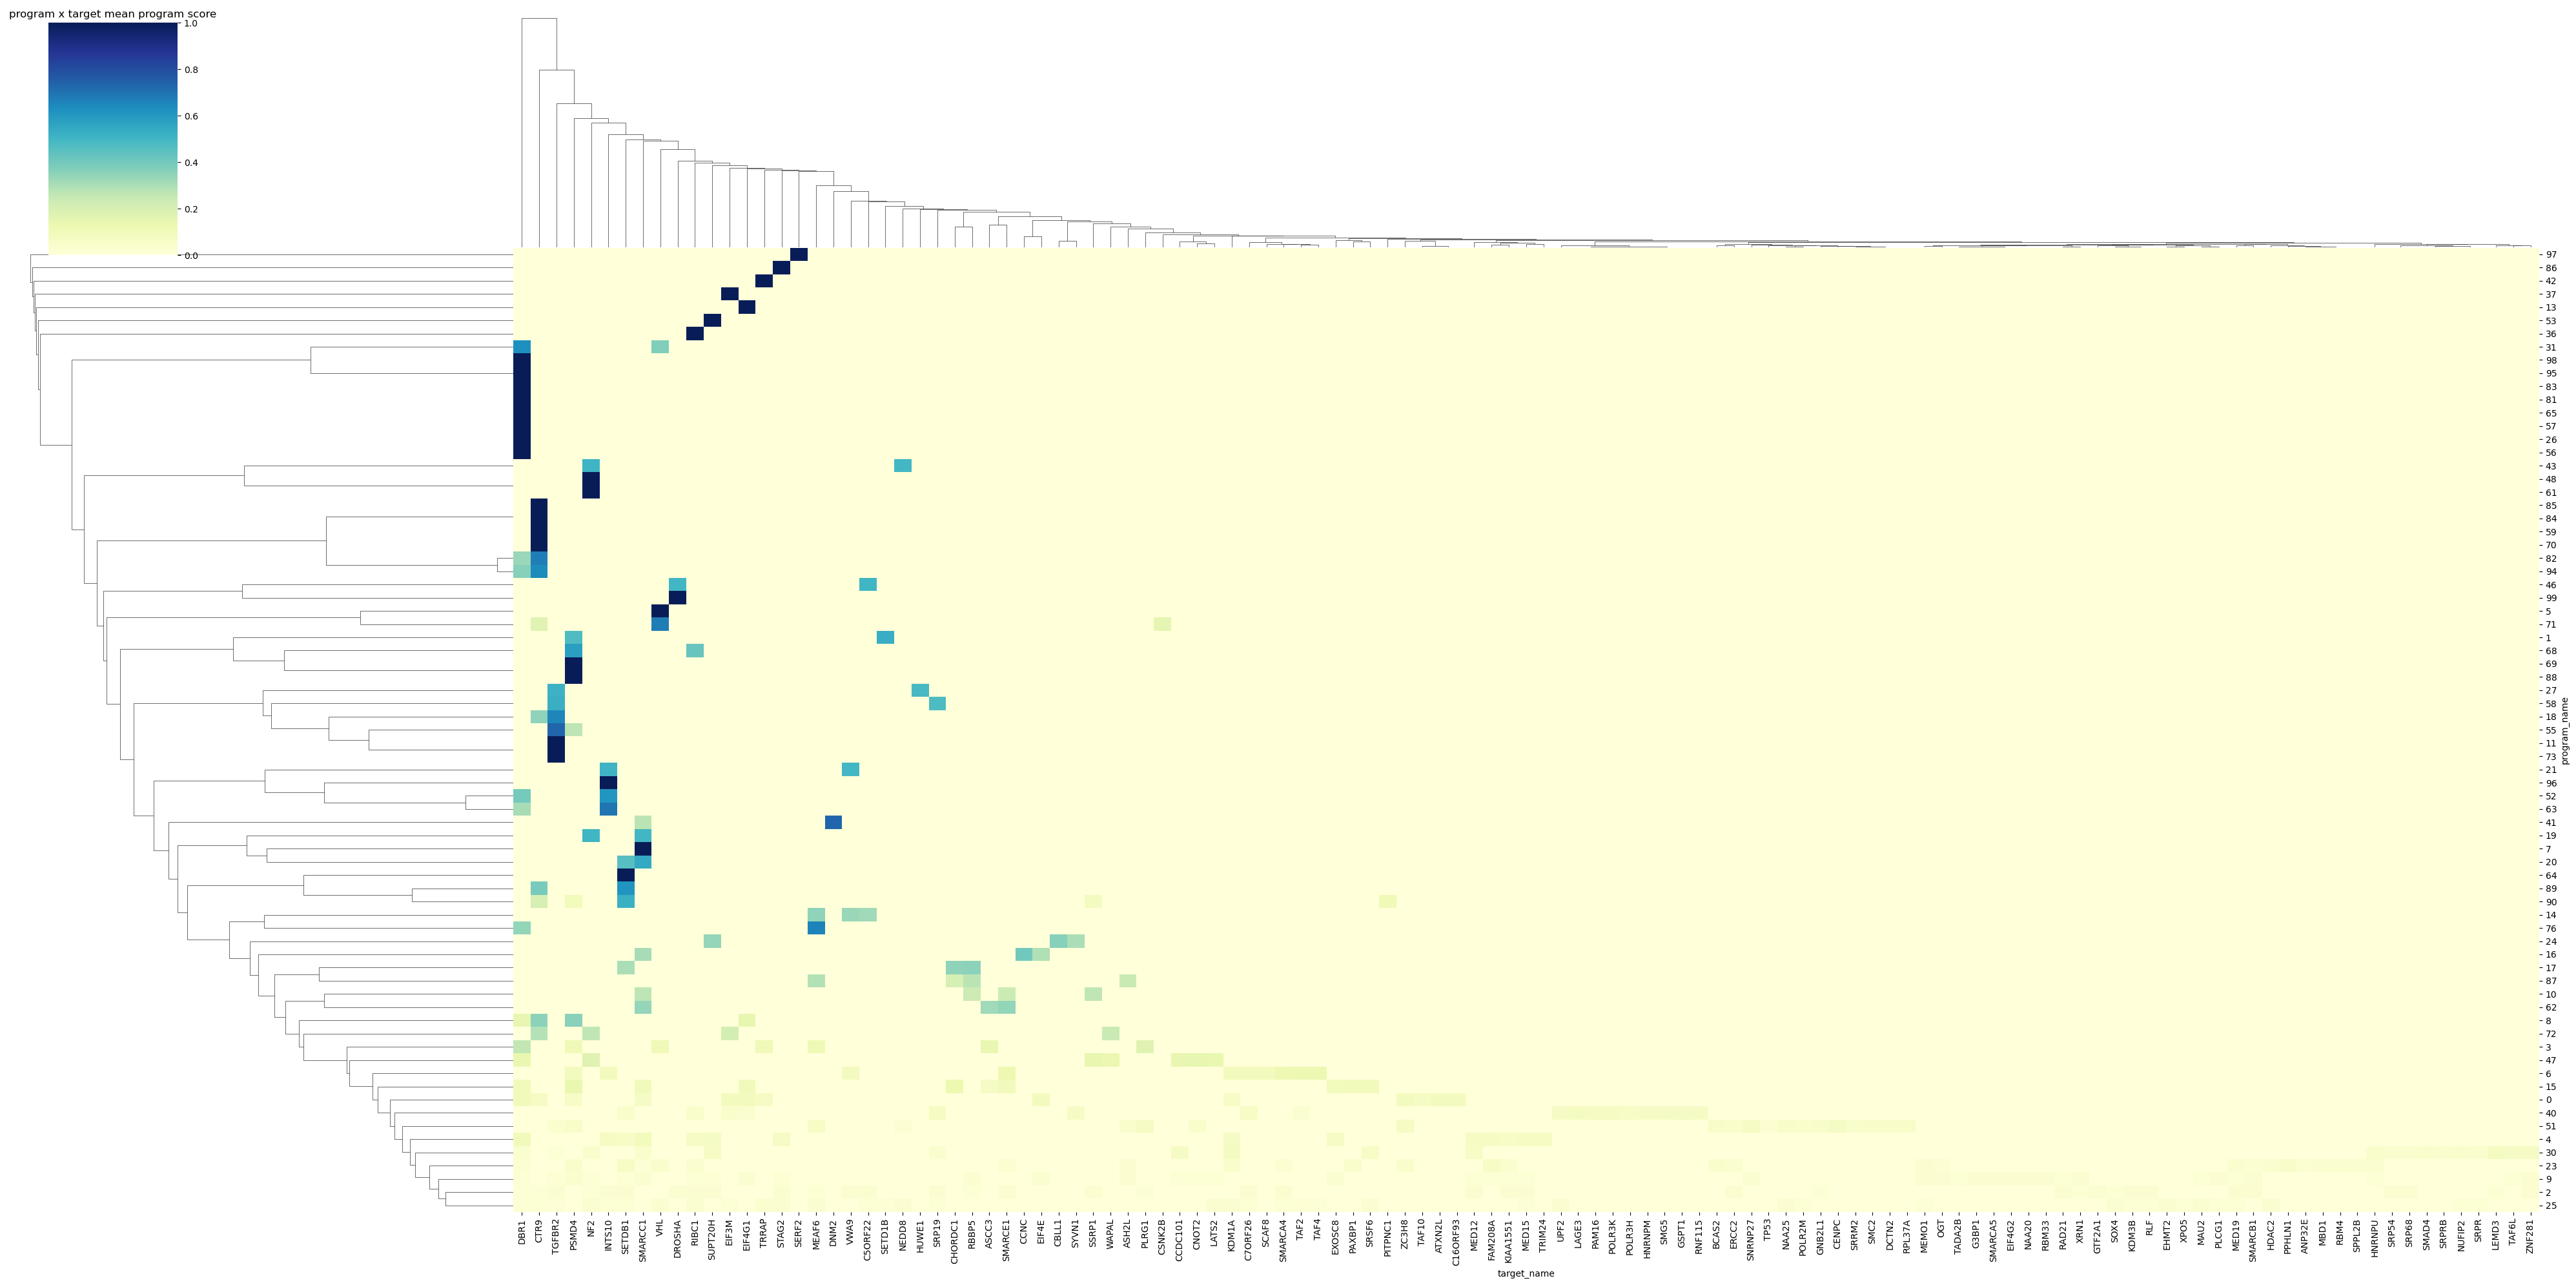

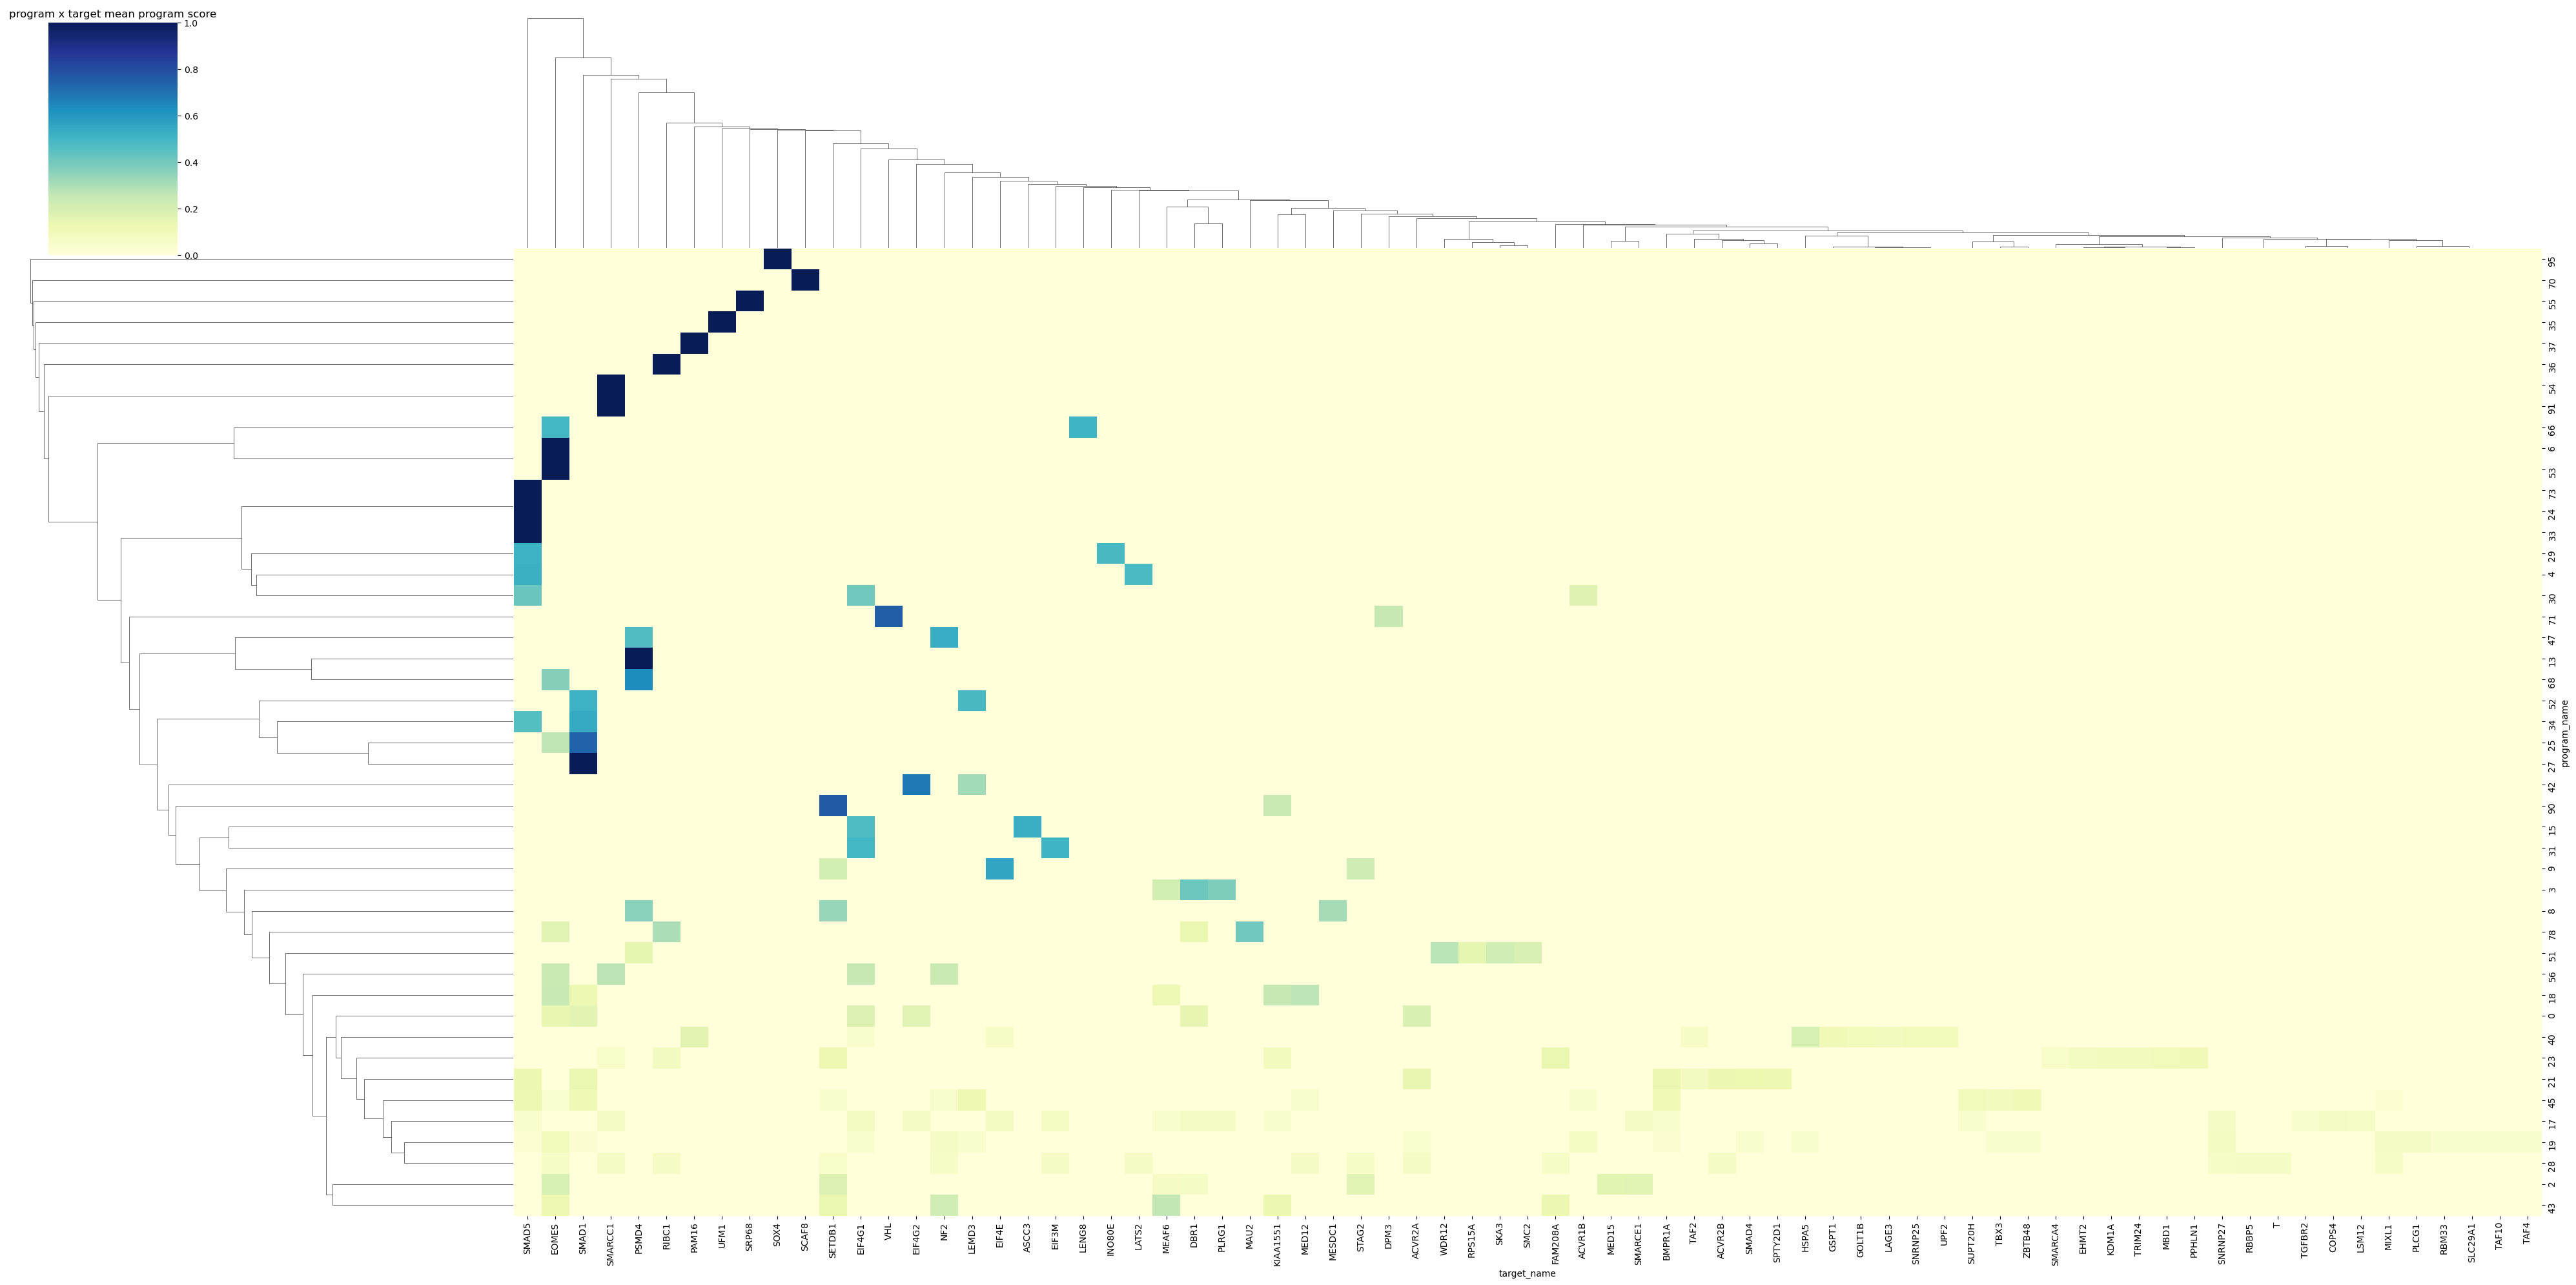

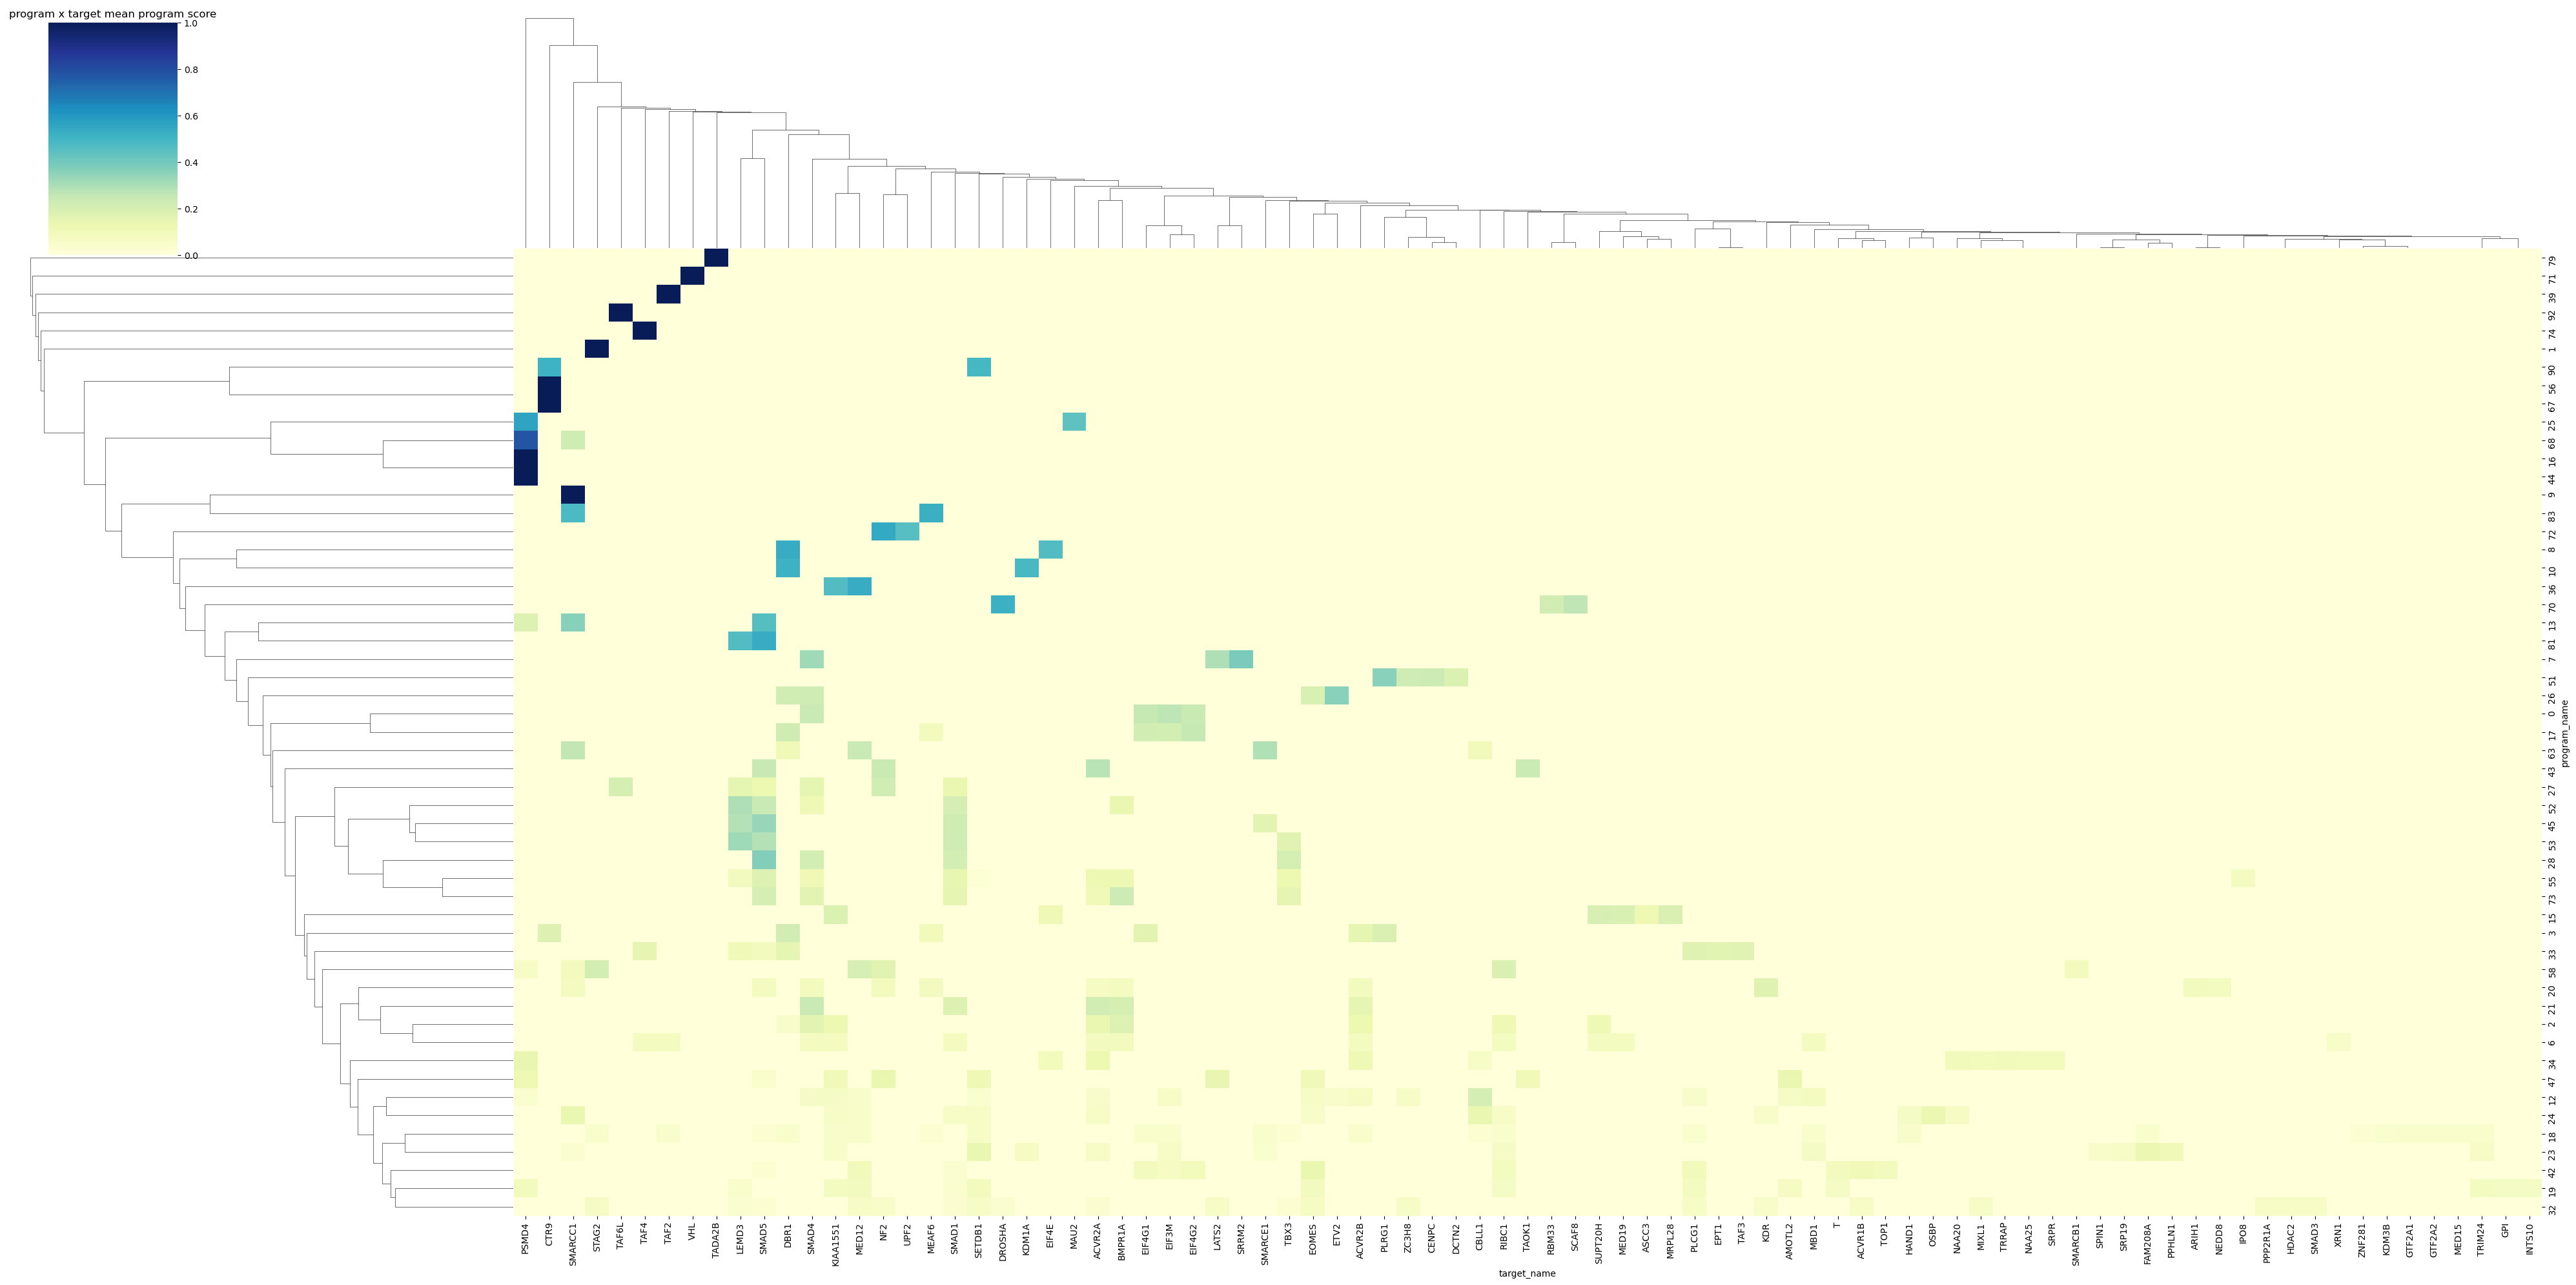

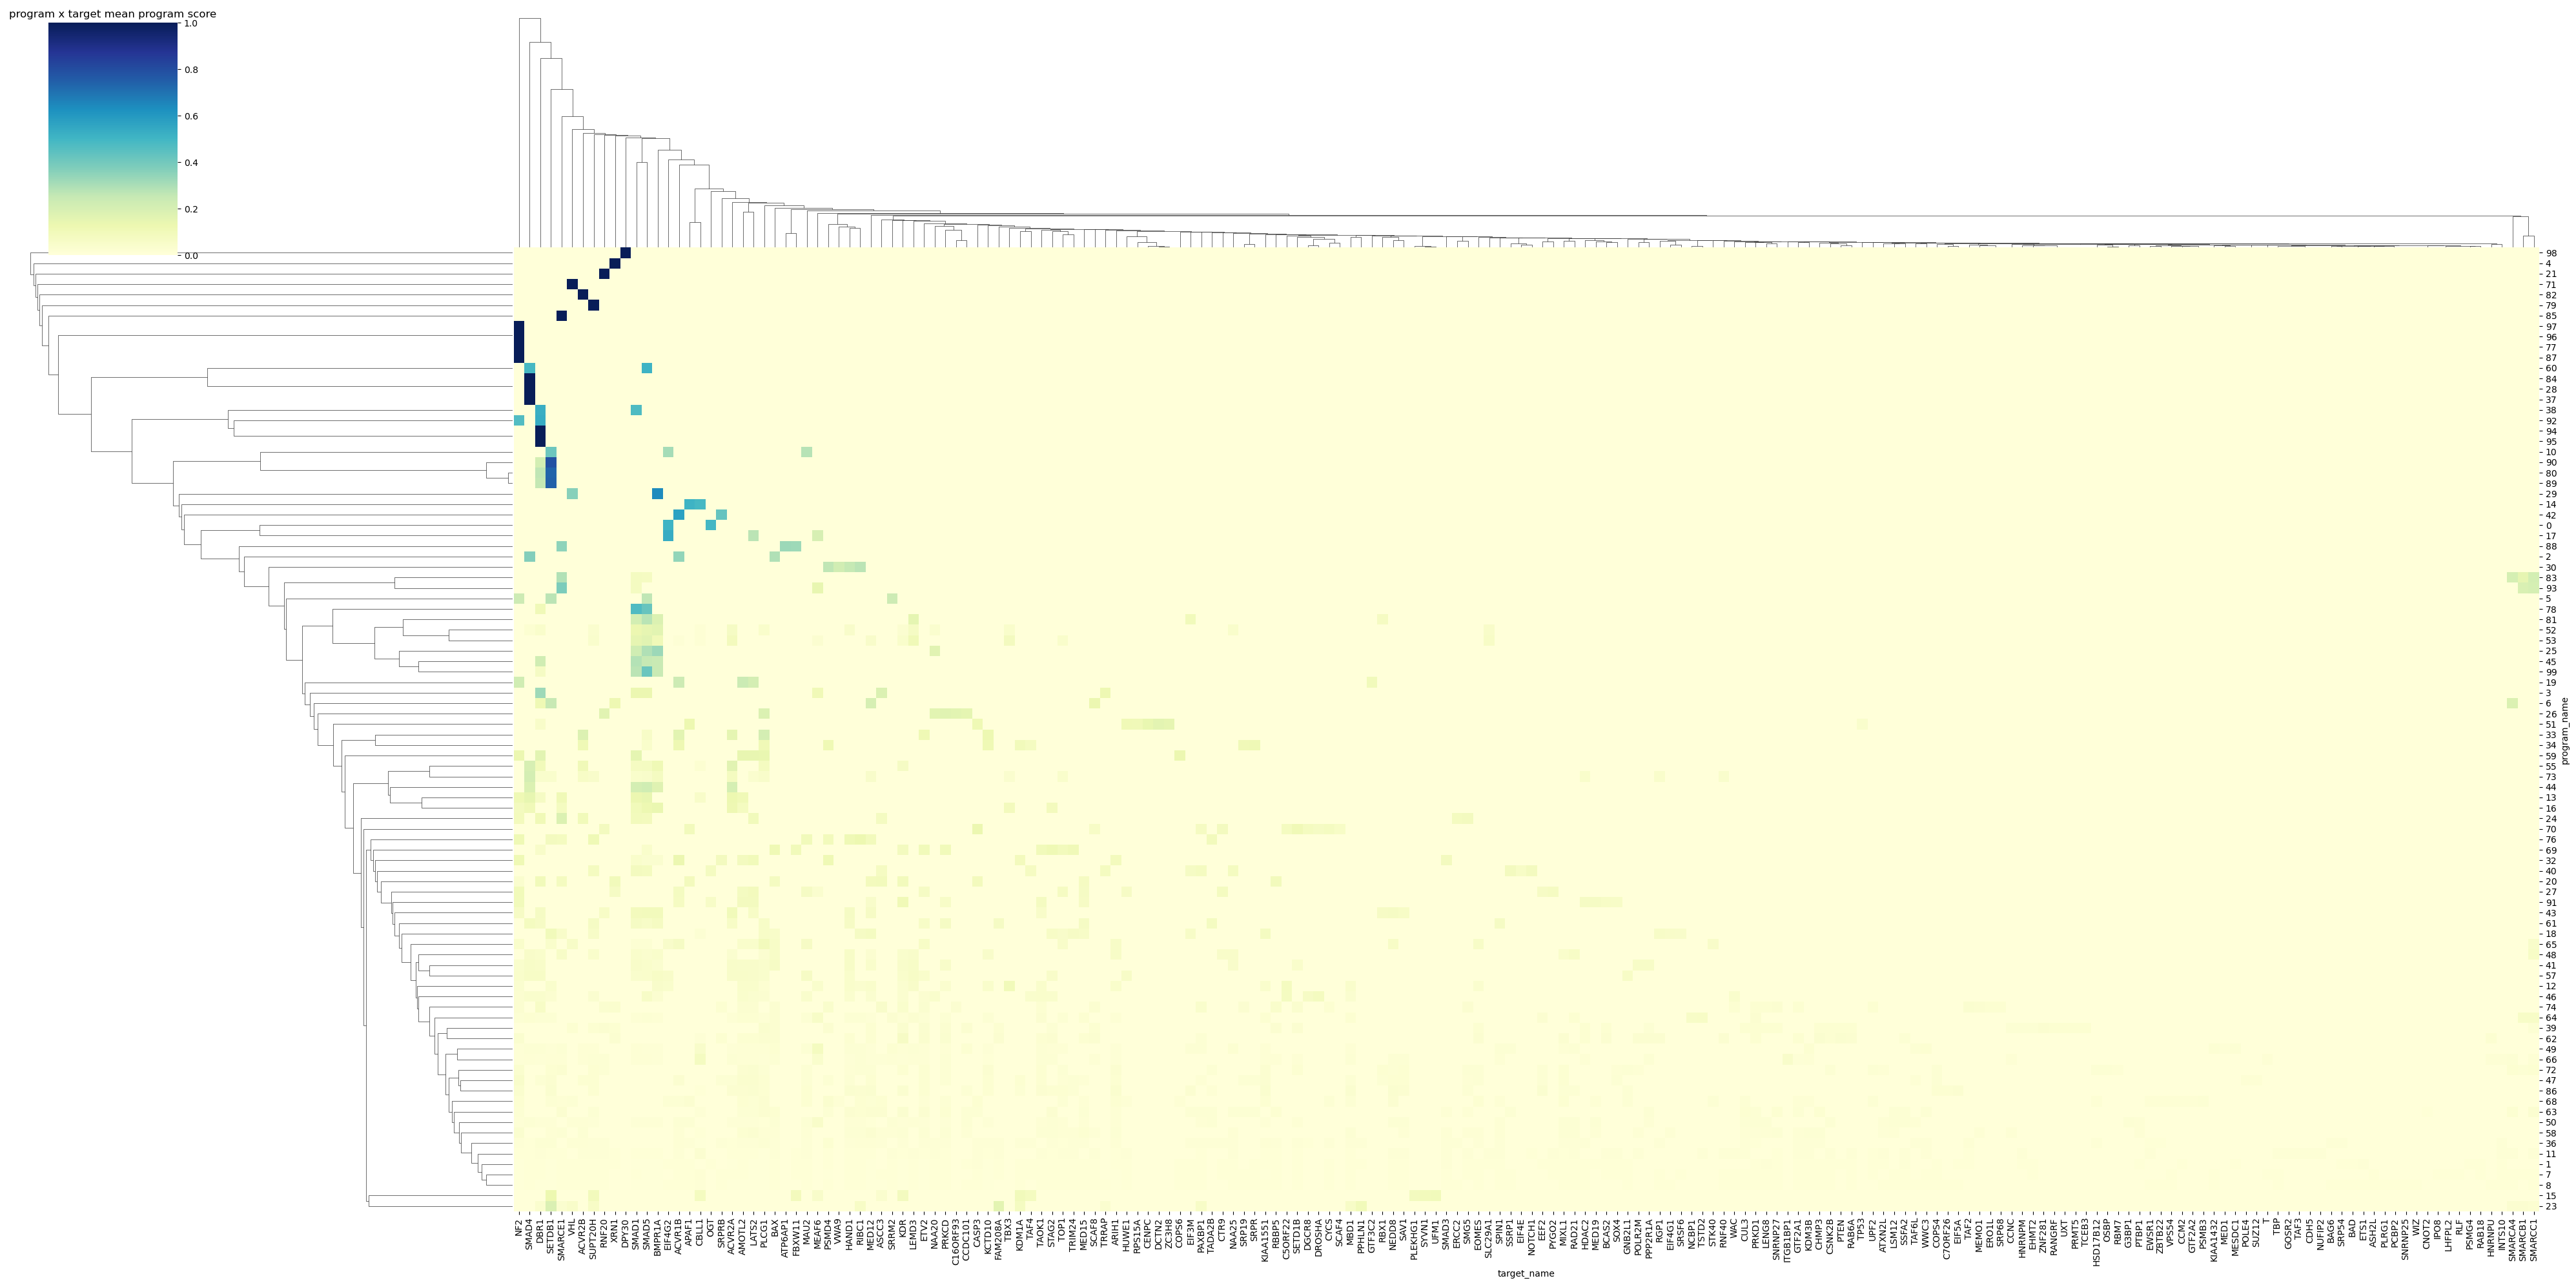

In [ ]:
# Heatmaps log2fc and mean score

for samp in perturb_df['sample'].unique():

    perturb_df_ = perturb_df.loc[perturb_df['sample']==samp]
    perturb_df_ = perturb_df_.loc[perturb_df_.pval<=0.000335]

    plot_df = perturb_df_.pivot(index='program_name', columns='target_name', values='mean_program_score').astype(float)
    plot_df.to_csv('{}/{}_program_x_target_cNMF_perturbation_effect_mean_score{}.txt'.format(sel_K, sel_K, samp), sep='\t')
    plot_df = plot_df.divide(plot_df.sum(1),0)
    plot_df = plot_df.fillna(0)

    sns.clustermap(plot_df, xticklabels=True, yticklabels=True, cmap='YlGnBu', figsize=(40,20))
    plt.title('program x target mean program score')
    plt.savefig('{}/{}_program_x_target_cNMF_perturbation_effect_mean_score{}.png'.format(sel_K, sel_K, samp), dpi=100)

In [ ]:
# Load guide target
guide_target = guide_metadata.copy()
non_targeting_idx = guide_target.index[guide_target.Target=='non-targeting']

guide_target = guide_target.loc[non_targeting_idx]

In [ ]:
# Actual data
test_stats_real_df = []
for k in [30, 60, 80, 100, 200, 250, 300]: # 400

    # Run perturbation assocation
    for samp in ['D0', 'sample_D1', 'sample_D2', 'sample_D3']:
        test_stats_df_ = pd.read_csv('../240807_cNMF_eval_pipeline_analysis/{}/{}_perturbation_association_results_{}.txt'.format(k,k,samp), sep='\t')
        test_stats_df_['sample'] = samp
        test_stats_df_['K'] = k
        #test_stats_df_['fdr'] = fdrcorrection(test_stats_df_['pval'])[1]
        test_stats_real_df.append(test_stats_df_)
test_stats_real_df = pd.concat(test_stats_real_df, ignore_index=True)
test_stats_real_df['real'] = True

In [ ]:
# # Calibrate tests using "fake_target guides"
# test_stats_dfs = []
# for i in range(10):

#     guide_target_ = guide_target.copy()
#     guide_target_.loc[guide_target_.OligoID.isin(np.random.choice(guide_target.OligoID, 15)), 'Target'] = 'targeting'

#     for k in [30, 60, 80, 100, 200, 250, 300]: # 400  

#         # Load mdata
#         mdata = mudata.read('../240701_cNMF/cNMF_{}_0.2_gene_names.h5mu'.format(k))  
#         mdata['cNMF'].obsm['guide_assignment'] = mdata['cNMF'].obsm['guide_assignment'][:, non_targeting_idx]
#         mdata['cNMF'].uns['guide_names'] = mdata['cNMF'].uns['guide_names'][non_targeting_idx]
#         mdata['cNMF'].uns['guide_targets'] = guide_target_.loc[guide_target_.OligoID==mdata['cNMF'].uns['guide_names'], 'Target'].values
        
#         # Run perturbation assocation
#         for samp in mdata['rna'].obs['sample'].unique():
#             mdata_ = mdata[mdata['rna'].obs['sample']==samp]
#             test_stats_df = compute_perturbation_association(mdata_, prog_key='cNMF', 
#                                                             collapse_targets=True,
#                                                             pseudobulk=False,
#                                                             reference_targets=('non-targeting'),
#                                                             n_jobs=-1, inplace=False)

#             test_stats_df['sample'] = samp
#             test_stats_df['K'] = k
#             test_stats_df['run'] = i
#             test_stats_dfs.append(test_stats_df)

# test_stats_dfs = pd.concat(test_stats_dfs)
# test_stats_dfs.to_csv('perturbation_association_calibration.txt', sep='\t', index=False)

In [ ]:
# Merge
test_stats_dfs['real'] =False
test_stats_dfs = pd.concat([test_stats_real_df, test_stats_dfs])

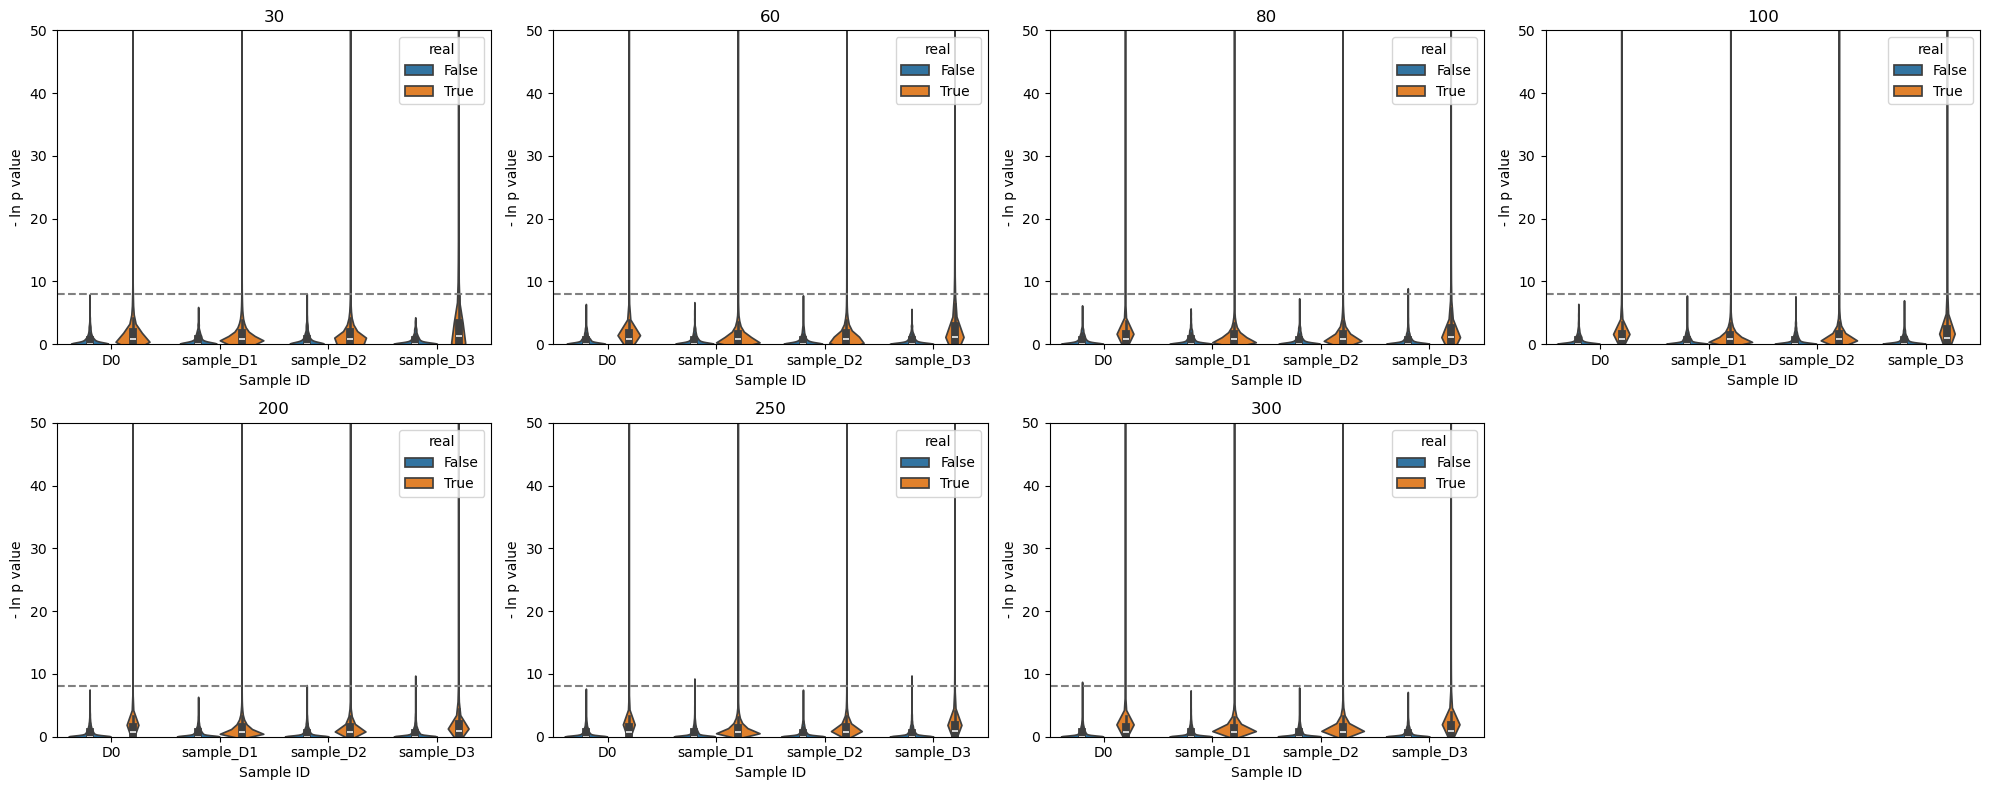

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,8))
for i,k in enumerate([30, 60, 80, 100, 200, 250, 300]):

    test_stats_dfs['neg_log_pval'] = test_stats_dfs['pval'].apply(lambda x: -np.log(x))
    sns.violinplot(x='sample', y='neg_log_pval', hue='real', data=test_stats_dfs.loc[test_stats_dfs.K==k], ax=axs.flat[i])
    axs.flat[i].set_title(str(k))
    axs.flat[i].set_xlabel('Sample ID')
    axs.flat[i].set_ylabel('- ln p value')
    axs.flat[i].set_ylim(0,50)
    axs.flat[i].axhline(8, color='grey', linestyle='dashed')

axs.flat[-1].axis('off')
plt.tight_layout()

plt.savefig('perturbation_association_calibration.png', dpi=100)

In [247]:
# Table with 1 row per program
# Columns for program, top 10 genes, top 10 enriched GO terms, genesets, traits, targets, motifs

overview_df = pd.DataFrame(index=perturb_df.program_name.unique(), 
                           columns=['variance_explained', 'top10_loaded_genes', 
                                    'top10_log2fc_targets', 'top10_fdr_targets', 
                                    'top10_enriched_genesets', 'top10_enriched_go_terms',
                                    'top10_enriched_traits', 'top10_enriched_motifs'])
# Make loadings
loadings = pd.DataFrame(mdata['cNMF'].varm['loadings'].T, index=mdata['cNMF'].uns['var_names'])

# Top 10 regulators
regulators = perturb_df.groupby(['target_name', 'program_name']).max().reset_index()
regulators['abs_log2fc_over_non_targeting_mean_program_score'] = regulators['log2fc_over_non_targeting_mean_program_score'].apply(lambda x: abs(x))

# Load enrichments
geneset_enrichment = pd.read_csv('100/100_geneset_enrichment.txt', sep='\t')
go_term_enrichment = pd.read_csv('100/100_GO_term_enrichment.txt', sep='\t')
trait_enrichment = pd.read_csv('100/100_trait_enrichment.txt', sep='\t')

for prog in overview_df.index.values:

    # Add loadings
    top10_loaded_genes = loadings[int(prog)].sort_values(ascending=False).head(10).index.tolist()
    overview_df.loc[prog, 'top10_loaded_genes'] = ', '.join(top10_loaded_genes)

    # Add regulators
    top10_log2fc_regulators = regulators.loc[regulators.program_name==prog].sort_values('abs_log2fc_over_non_targeting_mean_program_score', ascending=False).head(10).target_name.values
    overview_df.loc[prog, 'top10_log2fc_targets'] = ', '.join(top10_log2fc_regulators)

    top10_fdr_regulators = regulators.loc[regulators.program_name==prog].sort_values('fdr', ascending=True).head(10).target_name.values
    overview_df.loc[prog, 'top10_fdr_targets'] = ', '.join(top10_log2fc_regulators)

    # Add enrichments
    top10_genesets = geneset_enrichment.loc[geneset_enrichment.program_name==prog].sort_values('Adjusted P-value', ascending=True).head(10).Term.values
    overview_df.loc[prog, 'top10_enriched_genesets'] = ', '.join(top10_genesets)

    top10_go_terms = go_term_enrichment.loc[go_term_enrichment.program_name==prog].sort_values('Adjusted P-value', ascending=True).head(10).Term.values
    overview_df.loc[prog, 'top10_enriched_go_terms'] = ', '.join(top10_go_terms)

    top10_traits = trait_enrichment.loc[trait_enrichment.program_name==prog].sort_values('Adjusted P-value', ascending=True).head(10).Term.values
    overview_df.loc[prog, 'top10_enriched_traits'] = ', '.join(top10_traits)

overview_df.index.name=='program_name'
overview_df.to_csv('{}/{}_cNMF_evaluations_summary.txt'.format(sel_K, sel_K), sep='\t')



In [ ]:
# Categorical association - volcano & pairwise <- min pval plot
results_df = pd.read_csv('{}/{}_categorical_association_results.txt'.format(sel_K, sel_K), sep='\t')
posthoc_df = pd.read_csv('{}/{}_categorical_association_posthoc.txt'.format(sel_K, sel_K), sep='\t')

results_df['sample_kruskall_wallis_log10_stat'] = results_df['sample_kruskall_wallis_stat'].apply(lambda x: np.round(np.log10(x)))
results_df['sample_kruskall_wallis_fdr'] = fdrcorrection(results_df['sample_kruskall_wallis_pval'].values.flatten())[1]
results_df['sample_kruskall_wallis_neg_log10_fdr'] = results_df['sample_kruskall_wallis_fdr'].apply(lambda x: -np.log10(x))

fig, axs = plt.subplots(figsize=(15,7))

sns.scatterplot(x='sample_kruskall_wallis_stat', y='sample_kruskall_wallis_neg_log10_fdr', data=results_df, ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90)
axs.axhline(-np.log10(0.05), color='red', linestyle='dashed')

In [ ]:
# fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(40, 20))
# sns.boxplot(x='target', y='log10_n_counts', data=guide_metadata_df, ax=axs.flat[0])
# axs.flat[0].set_xticklabels([])

# sns.boxplot(x='target', y='log10_gene_count', data=guide_metadata_df, ax=axs.flat[1])
# axs.flat[1].set_xticklabels([])

# sns.boxplot(x='target', y='log10_tscp_count', data=guide_metadata_df, ax=axs.flat[2])
# axs.flat[2].set_xticklabels([])

# sns.boxplot(x='target', y='log10_mread_count', data=guide_metadata_df, ax=axs.flat[3])
# axs.flat[3].set_xticklabels(axs.flat[3].get_xticklabels(), rotation=90)

In [ ]:

for col in ['log10_n_counts', 'log10_gene_count', 'log10_tscp_count', 'log10_mread_count']:

    fml = '{} ~ 1'
    vcf = {'barcode': '0 + C(barcode)',
           'guide':'0 + C(guide)',
           'target':'0 + C(target)'
            }
    model = MixedLM.from_formula(fml, vc_formula=vcf, groups="sample", data=guide_metadata_df)                             
    result = model.fit(method='powell') 

    print('\n')
    print('##################################################################')
    print(col)
    print(result)
    print('##################################################################')
    print('\n')